<a name="exit"></a>
# Projet de Machine Learning : reconnaissance d'émotions

L'objectif de ce projet est d'utiliser un algorithme de deep-learning afin de reconnaître l'émotion d'une personne d'après la photo de son visage.

En raison du rôle important des émotions dans l'interaction humaine, la possibilité d'effectuer une reconnaissance automatique des émotions à l'aide de l'intelligence artificielle permet toute une série d'applications sur des champs tels que l'analyse de données et l'interaction homme-machine.


Nous entrainons ainsi un réseau afin qu'il réussisse à distinguer la bonne émotion parmi les 7 existantes dans notre programme : la colère, la joie, la tristesse, le dégout, la peur, la surprise et la neutralité (ou le mépris, selon le jeu de donnée).

Pour débuter, nous avons choisi un premier dataset contenant plus de 35000 images dans lesquelles on pouvait distinguer 7 émotions. 
Cependant, nous n'avons pas utilisé directement toutes les images, mais nous nous sommes réduits à étudier seulement 2 émotions en même temps, et de préférence des émotions assez facilement distinguable entre elles comme la tristesse et la joie, ou encore la surprise et la colère. 
Ceci nous a permis de développer un premier modèle pour commencer. Ce modèle nous a servi de première base et nous avons cherché à l'améliorer tout au long ce projet.

Progressivement, nous avons augmenté le nombre d'émotions étudiées, tout en essayant de toujours améliorer notre modèle et qu'il ait la meilleure précision possible. 

Nous avons également cherché plusieurs moyens de visualiser nos résultats. En effet, nous avons initialement essayé une simple visualisation basée sur les prédictions et créé un histogramme, mais cela ne nous donnait pas assez d'informations sur le modèle. Ensuite, nous sommes passés à une visualisation plus parlante, et nous avons décidé de tracer l'espace latent. Cela nous a permis de bien visualiser si notre modèle était efficace, grâce à une répartition des émotions en groupe sur un espace à 2 dimensions. Cette méthode nous a servi tantôt pour un faible nombre d'émotions que pour un grand nombre d'émotions.

En plus de l'espace latent, nous avons mis au point 3 autres méthodes de visualisation des résultats. Dans un premier temps, pour une image donnée, nous avons analysé le score correspondant à chaque émotion que l'on a regroupé dans un histogramme. Nous avons ensuite créé une matrice de précision qui nous donne le taux de précision pour des paires d'émotions. Finalement, nous avons utilisé la courbe ROC (Receiver Operating Characteristic) pour déterminer le degré de séparabilité des émotions.

\

---

\
Lien d'origine des données utilisées :

[dataset FER2013](https://www.kaggle.com/ahmedmoorsy/facial-expression)
: 35887 images sous forme d'un fichier csv

[dataset CK+](https://www.kaggle.com/shawon10/ckplus)
: 981 images en format .png

[dataset KDEF](https://www.kdef.se/index.html)
: 2343 images en format .jpg


\
Aide à la compréhension de l'espace latent, du manifold et des courbes ROC :

[Espace Latent et manifold](https://towardsdatascience.com/understanding-latent-space-in-machine-learning-de5a7c687d8d)

[Courbes ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)

\

---

\

Ouvrir ce document de préférence sur google colab pour les widgets et les animations.

# Sommaire


* ##   [Importation des données et modules](#S1)
> ### [1er jeu de données : FER2013](#S3)
> ### [2ème jeu de données : CK+](#S4)
> ### [3ème jeu de données : KDEF](#S5)
> ### [Sélection des datasets](#S6)


* ## [Création des données d'entrainement et de test](#S7)
> ### [Choix d'émotions](#S8)


* ## [Passage au deep-learning](#S9)
> ### [Modèle 1 ](#S10)
> ### [Modèle 2 ](#S11)
> ### [Création de callbacks](#S12)
> ### [Entrainement du réseau ](#S13)


* ## [Visualisation des résultats](#S16)
> ### [Exemples de prédictions](#S17)
> ### [Espace latent](#S18)
> ### [Courbe ROC](#S19)
> ### [Matrice de précision](#S20)

* ## [Conclusion ](#S21)

<a name="S1"></a>
# Importation des données et modules 


In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
cd drive/My\ Drive/Machine_Learning

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import ipywidgets as widgets

from matplotlib import animation
from IPython.display import HTML

from sklearn.model_selection import train_test_split
from sklearn import manifold
from sklearn.metrics import roc_curve, auc
from keras.models import (Model, model_from_json)
from keras.layers import (
    Dense,
    Conv2D,
    MaxPooling2D,
    BatchNormalization,
    Dropout,
    Input,
    Flatten,
    concatenate
    )
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
from keras.preprocessing import image

Using TensorFlow backend.


## Récupération des données, informations et sélection

In [0]:
Emotions_labels = ['colère','dégoût','peur','joie','tristesse','surprise','neutre']

def show_dataset_infos(pix, emot, ajust, num, *arg):
    
    if arg:
        Emotions_labels[-1]='mépris'

    # imshow des émotions
    print("Images d'exemple du dataset et leurs émotions associées:")
    fig, ax = plt.subplots(nrows=1, ncols=7, figsize=(16,16))
    for i in range(7):
        ax[i].set_title('{}'.format(Emotions_labels[i]))
        ax[i].imshow(pix[emot==i][num].reshape(48,48), cmap='gray')
        ax[i].set_axis_off()

    plt.tight_layout()
    plt.show()


    # nombre d'images par émotions
    nb_pix_per_emotions = [sum(emot==i) for i in range(7)]
    print("\n Nombre total d'images sur ce dataset :",sum(nb_pix_per_emotions))


    # barplot des émotions
    print("\n Répartition des émotions :")
    plt.figure(figsize=(8,6))
    plt.bar(np.arange(7), nb_pix_per_emotions, align='center', color='blue')
    plt.xticks(np.arange(7), Emotions_labels)

    for i, v in enumerate(nb_pix_per_emotions):
        plt.text(i-0.2, v+ajust, str(v), c='blue')
        
    plt.show()

<a name="S3"></a>
### 1er jeu de données : FER2013

#### Informations

FER2013 est un jeu de données de 35887 images illustrant les variations d'éclairage, d'âge, de pose, d'intensité d'expression et d'occultations qui se produisent dans des conditions réalistes. 

Les visages de ce dataset sont donc présents sous différents angles mais on retrouve aussi des éléments perturbateurs comme des lunettes, des mains, du texte ou autre. 
Parfois les visages ne sont même pas humains, on retrouve aussi des images sans visage et on a aussi des émotions qui ne correspondent pas à l'image. Il y a donc des erreurs incrustées dans ce dataset pour compliquer la tâche.

In [0]:
Pix1 = np.load('datas/FER/FER2013.npy') # tab2D des 35887 images flatten()

emotions1 = np.load('datas/FER/emotions.npy') # tab1D des émotions associées aux images

In [0]:
np.save('FER2013', Pix1)

Visualisation et répartition des données

Images d'exemple du dataset et leurs émotions associées:


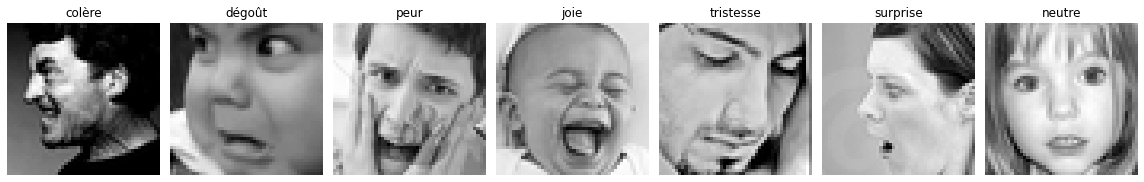


 Nombre total d'images sur ce dataset : 35887

 Répartition des émotions :


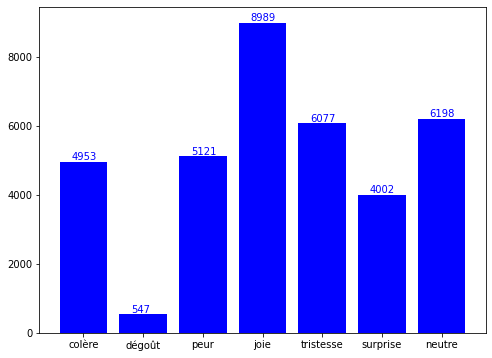

In [0]:
show_dataset_infos(Pix1, emotions1, 50, 12)

#### Exemples d'anomalies

 Visage non humain : 

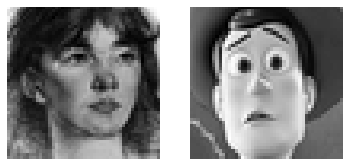

In [0]:
fig, ax = plt.subplots(nrows=1,ncols=2)
ax[0].imshow(Pix1[emotions1==6][5].reshape(48,48), cmap='gray') ; ax[0].set_axis_off()
ax[1].imshow(Pix1[emotions1==2][100].reshape(48,48), cmap='gray') ; ax[1].set_axis_off()

plt.show()

 Pas de visage dans l'image :

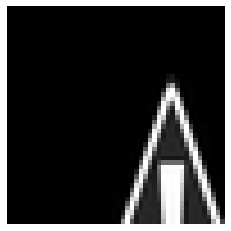

In [0]:
fig, ax = plt.subplots(nrows=1,ncols=1)
ax.imshow(Pix1[emotions1==2][10].reshape(48,48), cmap='gray') ; ax.set_axis_off()

plt.show()

Visage avec texte par dessus :

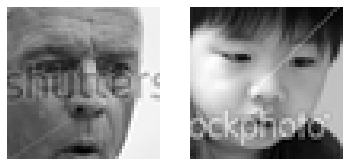

In [0]:
fig, ax = plt.subplots(nrows=1,ncols=2)
ax[0].imshow(Pix1[emotions1==5][25].reshape(48,48), cmap='gray') ; ax[0].set_axis_off()
ax[1].imshow(Pix1[emotions1==6][20].reshape(48,48), cmap='gray') ; ax[1].set_axis_off()

plt.show()

Mauvaise émotion associée :

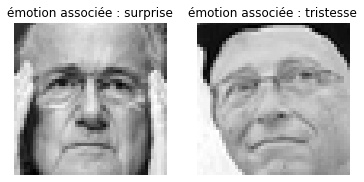

In [0]:
fig, ax = plt.subplots(nrows=1,ncols=2)

ax[0].set_title('émotion associée : '+Emotions_labels[5])
ax[0].imshow(Pix1[emotions1==5][8].reshape(48,48), cmap='gray') ; ax[0].set_axis_off()

ax[1].set_title('émotion associée : '+Emotions_labels[4])
ax[1].imshow(Pix1[emotions1==4][13].reshape(48,48), cmap='gray') ; ax[1].set_axis_off()

plt.show()

On retrouve aussi des mains sur l'image de gauche ci-dessus et les deux personnes portent des lunettes.

#### Création d'un petit jeu de données égalisées, issu de FER2013

Dans le but de comparer le jeu de données FER2013 et les jeux de données suivants comportant beaucoup moins d'images, on crée une copie réduite de FER2013. On égalise aussi le nombre d'image dans chaque émotion pour obtenir de meilleurs résultats.

In [0]:
indices_random = np.random.randint(0, 547, 400)

Pix1_equal = [ Pix1[emotions1==i][indices_random] for i in range(7) ] 
emo1_equal = [ emotions1[emotions1==i][indices_random] for i in range(7) ]

Pix1_equal = np.concatenate(np.array(Pix1_equal))
emo1_equal = np.concatenate(np.array(emo1_equal))

Images d'exemple du dataset et leurs émotions associées:


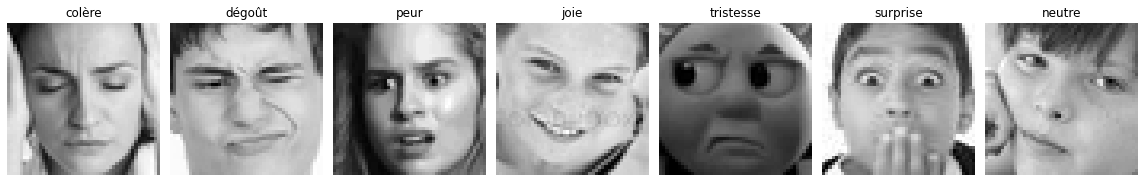


 Nombre total d'images sur ce dataset : 2800

 Répartition des émotions :


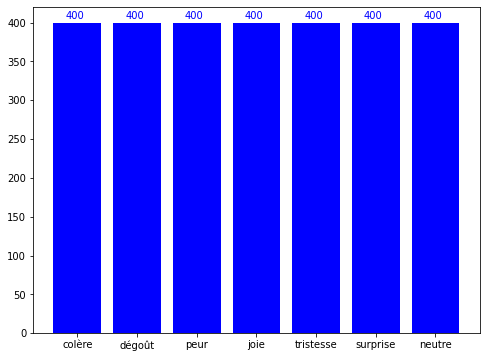

In [0]:
show_dataset_infos(Pix1_equal, emo1_equal, 5, 12)

<a name="S4"></a>
### 2e jeu de données : CK+

CK+ est un jeu de données de 981 visages d'adultes. Tous les visages sont de face, en gros plan et il n'y a pas de perturbation comme des mains, des lunettes ou autre. Les émotions sont correctement annotées. C'est donc un dataset exact, sans erreurs.

Les 7 émotions sont : colère, dégoût, peur, joie, tristesse, surprise et mépris. (Différence avec les autres datasets qui comportent l'émotion neutre au lieu de mépris)

In [0]:
Pix2 = np.load('datas/CKplus/CKplus.npy') # tab2D des 981 images flatten()

emotions2 = np.load('datas/CKplus/emotions_ck.npy') # tab1D des émotions associées aux images

Visualisation et répartition des données

Images d'exemple du dataset et leurs émotions associées:


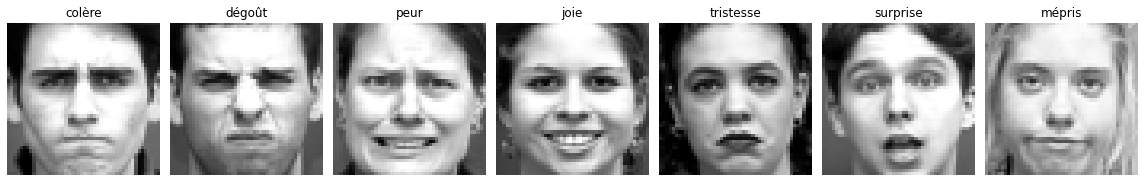


 Nombre total d'images sur ce dataset : 981

 Répartition des émotions :


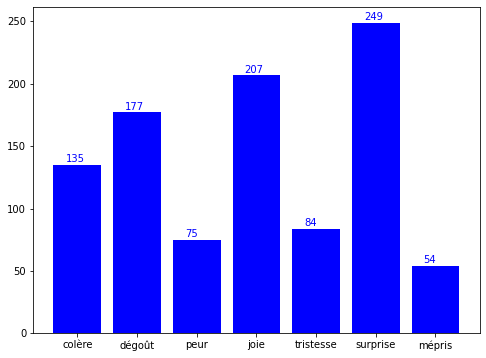

In [0]:
show_dataset_infos(Pix2, emotions2, 2, 11, True)

<a name="S5"></a>
### 3e jeu de données : KDEF

#### Extraction

Pour extraire les données du dataset KDEF nous avons utilisé la class suivante.

Les images étaient sous forme de fichiers .jpg dont les noms correspondaient à l'émotion de la personne et à d'autres paramètres.

In [0]:
import os
import cv2

class DataManager(object):
    """Class for loading fer2013 emotion classification dataset or
        imdb gender classification dataset."""
    def __init__(self, dataset_name, dataset_path, image_size=(48, 48)):

        self.dataset_name = dataset_name
        self.dataset_path = dataset_path
        self.image_size = image_size
        if self.dataset_path is not None:
            self.dataset_path = dataset_path
        elif self.dataset_name == 'KDEF':
            self.dataset_path = 'datas/KDEF/'
        else:
            raise Exception(
                    'Incorrect dataset name, please input imdb or fer2013')

    def get_data(self):
        if self.dataset_name == 'KDEF':
            ground_truth_data = self._load_KDEF()
        return ground_truth_data


    def _load_KDEF(self):
        class_to_arg = get_class_to_arg(self.dataset_name)
        num_classes = len(class_to_arg)

        file_paths = []
        for folder, subfolders, filenames in os.walk(self.dataset_path):
            for filename in filenames:
                if filename.lower().endswith(('.jpg')):
                    file_paths.append(os.path.join(folder, filename))

        num_faces = len(file_paths)
        y_size, x_size = self.image_size
        faces = np.zeros(shape=(num_faces, y_size, x_size))
        emotions = np.zeros(shape=(num_faces, num_classes))
        for file_arg, file_path in enumerate(file_paths):
            image_array = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            image_array = cv2.resize(image_array, (y_size, x_size))
            faces[file_arg] = image_array
            file_basename = os.path.basename(file_path)
            file_emotion = file_basename[4:6]
            # there are two file names in the dataset
            # that don't match the given classes
            try:
                emotion_arg = class_to_arg[file_emotion]
            except:
                continue
            emotions[file_arg, emotion_arg] = 1
        faces = np.expand_dims(faces, -1)
        emotions = np.argmax(emotions, axis=1)
        return faces, emotions


def get_class_to_arg(dataset_name):
    if dataset_name == 'KDEF':
        return {'AN': 0, 'DI': 1, 'AF': 2, 'HA': 3, 'SA': 4, 'SU': 5, 'NE': 6}


In [0]:
input_shape = (48, 48, 1)
dataset_name = 'KDEF'
data_loader = DataManager(dataset_name, None, image_size=input_shape[:2])

Pix, emotions = data_loader.get_data()

#### Informations

KDEF est un jeu de données de 2343 visages d'adultes. Les visages sont sous 5 angles différents et le plan de la photo est plus élargi que sur les autres datasets, la qualité des expressions est donc moins bonne. On retrouve aussi chaque personne sous différents angles et avec chaque émotion.

In [0]:
Pix3 = np.load('datas/KDEF/KDEF.npy') # tab2D des 2343 images flatten()

emotions3 = np.load('datas/KDEF/emotions_KDEF.npy') # tab1D des émotions associées aux images

Visualisation et répartition des données

Images d'exemple du dataset et leurs émotions associées:


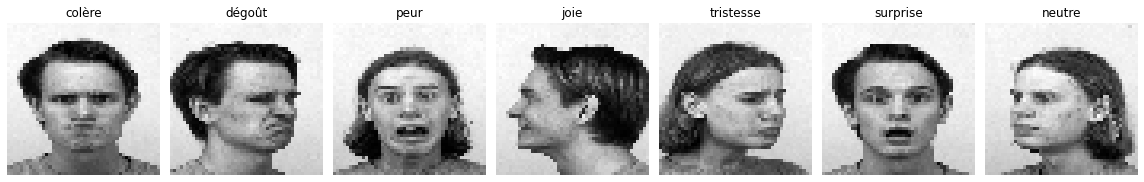


 Nombre total d'images sur ce dataset : 2343

 Répartition des émotions :


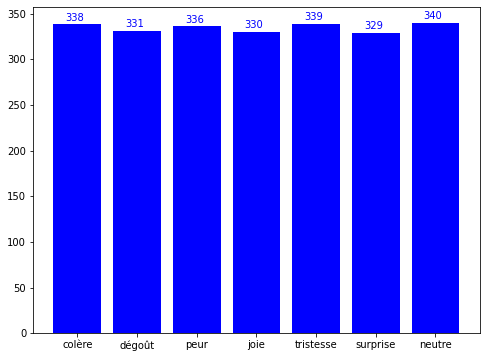

In [0]:
show_dataset_infos(Pix3, emotions3, 4, 33)

<a name="S6"></a>
### Sélection des datasets

In [0]:
datasets_name = ['FER2013', 'FER2013_small','CK+','KDEF']

caption = widgets.Label(value='Choisir un dataset')
choice = [widgets.Checkbox(description=datasets_name[i]) for i in range(len(datasets_name))]

display(caption, *choice)

Label(value='Choisir un dataset')

Checkbox(value=False, description='FER2013')

Checkbox(value=False, description='FER2013_small')

Checkbox(value=False, description='CK+')

Checkbox(value=False, description='KDEF')

In [0]:
# Récupération des jeux de données choisis

PIX = [Pix1, Pix1_equal, Pix2, Pix3]
EMOT = [emotions1, emo1_equal, emotions2, emotions3]

# si le dataset CK+ a été séléctionné avec un autre dataset :
conflit = choice[2].value==1 and sum([choice[i].value==1 for i in range(len(choice))])>=2
if conflit : 
    for i in range(len(PIX)):
        # on enlève les émotions 'neutre' et 'mépris' qui ne sont pas présentes dans tous les datasets
        PIX[i]=PIX[i][EMOT[i]!=6] 
        EMOT[i]=EMOT[i][EMOT[i]!=6]

    dataset_i = []
    emot_i = []
    print("Dataset(s) séléctionné(s) :")
    for i in range(len(choice)):
        if choice[i].value==1:
            dataset_i.append(PIX[i])
            emot_i.append(EMOT[i])
            print(datasets_name[i], ", nombre d'images :", len(dataset_i[-1]))

    Pix = np.concatenate(np.array(dataset_i))
    emotions = np.concatenate(np.array(emot_i))
    print("\nRéduction du nombre d'émotions et d'images du fait du conflit d'émotion entre les datasets.")

else : # si CK+ n'est pas dans la sélection
    dataset_i = []
    emot_i = []
    print("Dataset(s) séléctionné(s) :")
    for i in range(len(choice)):
        if choice[i].value==1:
            dataset_i.append(PIX[i])
            emot_i.append(EMOT[i])
            print(datasets_name[i], ", nombre d'images :", len(dataset_i[-1]))

    Pix = np.concatenate(np.array(dataset_i))
    emotions = np.concatenate(np.array(emot_i))

print("\nNombre d'éléments :", Pix.shape[0])

Dataset(s) séléctionné(s) :
FER2013 , nombre d'images : 35887

Nombre d'éléments : 35887


<a name="S7"></a>
## Création de tableaux à n émotions pour l'entrainement du réseau

On récupère les données en fonction du nombre d'émotions souhaitées. 

In [0]:
def datas(list_emot):

    # sélection des images en fonction des émotions choisies
    pix_nb = [ Pix[emotions==list_emot[i]] for i in range(len(list_emot)) ]
    pix_conca = np.concatenate(pix_nb)

    # sélection des émotions
    emot_nb = [ emotions[emotions==list_emot[i]] for i in range(len(list_emot)) ]
    emot_conca = np.concatenate(emot_nb)

    # changements de dimensions
    Pix_nb_em = pix_conca.reshape((pix_conca.shape[0],48,48)) # de 2 à 3 dimensions
    Pix_nb_em = np.expand_dims(Pix_nb_em,-1) # de 3 à 4 dimensions, to add one channel

    return Pix_nb_em, emot_conca

<a name="S8"></a>
### Choix d'émotions


In [0]:
caption1 = widgets.Label(value='Choisir au moins 2 émotion')
caption2 = widgets.Label(value='Sélectionner toutes les émotions disponibles')

if len(Pix)==len(Pix2):
    Emotions_labels[-1]='mépris'
else: 
    Emotions_labels[-1]='neutre'

check = [widgets.Checkbox(description='{}'.format(Emotions_labels[i])) for i in range(7)]
if conflit:
    check[-1] = widgets.Checkbox(description='Non disponible', disabled=True)


check2 = widgets.ToggleButton(value=False,description='Tout sélectionner')

display(caption1, *check)
display(caption2, check2)

Label(value='Choisir au moins 2 émotion')

Checkbox(value=False, description='colère')

Checkbox(value=False, description='dégoût')

Checkbox(value=False, description='peur')

Checkbox(value=False, description='joie')

Checkbox(value=False, description='tristesse')

Checkbox(value=False, description='surprise')

Checkbox(value=False, description='neutre')

Label(value='Sélectionner toutes les émotions disponibles')

ToggleButton(value=False, description='Tout sélectionner')

In [0]:
# récupération du choix d'émotions

if not check2.value:
    list_emotions=np.zeros(len(check))
    for i in range(len(check)):
        if check[i].value==1:
            list_emotions[i] = i+1 # +1 pour ne pas delete un 0 choisi

    list_emotions = np.delete(list_emotions, np.argwhere(list_emotions==0))
    list_emotions-=1 # -1 pour annuler le +1 précédent
else:
    if conflit:
        list_emotions = np.arange(6)
    if not conflit:
        list_emotions=np.arange(7)

list_emotions

array([0, 1, 2, 3, 4, 5, 6])

In [0]:
# tableaux des images et émotions associées
Pix_nb, Emot_nb = datas(list_emotions)

for i in range(len(list_emotions)):
    print("Nombre d'images avec l'émotion", Emotions_labels[int(list_emotions[i])], sum(Emot_nb==list_emotions[i]))
print("\nNombre d'éléments :", Emot_nb.shape[0])

Nombre d'images avec l'émotion colère 4953
Nombre d'images avec l'émotion dégoût 547
Nombre d'images avec l'émotion peur 5121
Nombre d'images avec l'émotion joie 8989
Nombre d'images avec l'émotion tristesse 6077
Nombre d'images avec l'émotion surprise 4002
Nombre d'images avec l'émotion neutre 6198

Nombre d'éléments : 35887


In [0]:
# transformation du tableau des émotions
# chaque émotion devient un tableau de 7 valeurs nulles sauf à l'emplacement de l'émotion considérée
Emot_nb = pd.get_dummies(pd.Series(Emot_nb)).values.astype(None)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(Pix_nb, Emot_nb, test_size=0.1)

<a name="S9"></a>
# Passage au deep-learning


<a name="S10"></a>
## Modèle 1 

Ce modèle nous a servi de première base pour la reconnaissance d'émotions. Il consiste en plusieurs couches successives de convolution et maxpooling, avec des couches cachées de neurones à la fin.

In [0]:
imageSize = 48
nb_features = 64

def getModel_1(Output_shape):
    input_img = Input(shape=(imageSize, imageSize, 1))
    
    # Convolutions
    x = Conv2D(nb_features, (3,3), activation="relu", padding='same')(input_img)
    x = Conv2D(nb_features, (3,3), activation="relu", padding='same')(x)
    x = BatchNormalization()(x) # Normalise les activations de la couche précédente à chaque batch
    x = MaxPooling2D(2,2)(x)
    x = Dropout(0.4)(x)

    x = Conv2D(nb_features*2, (3,3), activation="relu", padding='same')(x)
    x = Conv2D(nb_features*2, (3,3), activation="relu", padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2,2)(x)
    x = Dropout(0.4)(x)

    x = Conv2D(nb_features*2*2, (3,3), activation="relu", padding='same')(x)
    x = Conv2D(nb_features*2*2, (3,3), activation="relu", padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2,2)(x)
    x = Dropout(0.4)(x)

    x = Conv2D(nb_features*2*2*2, (3,3), activation="relu", padding='same')(x)
    x = Conv2D(nb_features*2*2*2, (3,3), activation="relu", padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2,2)(x)
    x = Dropout(0.4)(x)

    x = Flatten()(x)

    # hidden layers
    x = Dense(nb_features*2*2*2, activation='relu')(x)
    x = Dense(nb_features*2*2, activation='relu')(x)
    x = Dense(nb_features*2, activation='relu')(x)
    E = Dense(16, activation='relu')(x)

    # output
    z = Dense(Output_shape, activation='softmax')(E)

    last_dense = Model(input_img,E)
    encoder = Model(input_img,z)

    return encoder, last_dense

In [0]:
output_shape = len(list_emotions) # nombre de neurones de la sortie du modèle

encoder, last_dense = getModel_1(output_shape)
encoder.summary()

encoder.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['acc'])

Model: "model_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d_127 (Conv2D)          (None, 48, 48, 64)        640       
_________________________________________________________________
conv2d_128 (Conv2D)          (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization_75 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_119 (MaxPoolin (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_129 (Conv2D)          (None, 24, 24, 128)       738

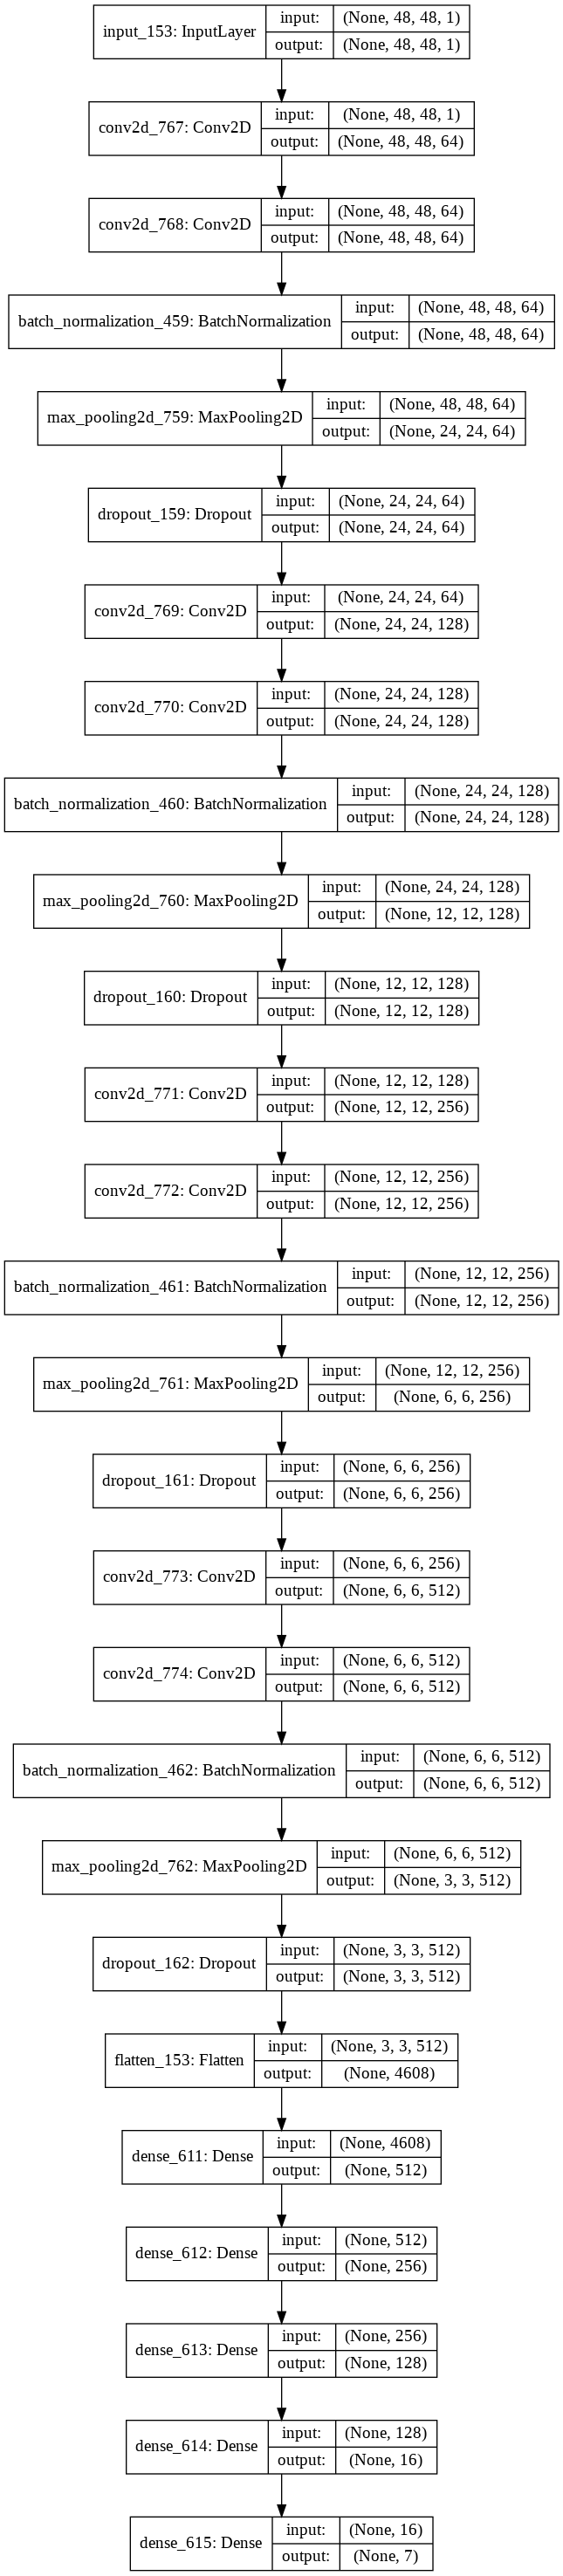

In [0]:
plot_model(encoder, show_shapes=True)

En testant ce modèle sur les datasets CK+ et KDEF les résultats étaient mauvais puisque la précision ne dépassait pas les 20% pour 7 émotions.

Nous avons donc pensé à faire un autre type de modèle, qui ne fait pas de convolutions successives.

Dans cette optique, nous avons abouti au modèle suivant, qui a une précision supérieure et dont la vitesse d'exécution est plus rapide.

<a name="S11"></a>
## Modèle 2

Dans ce modèle, nous avons implémenté plusieurs couches de convolution en parallèle afin d'étudier l'image à différentes échelles. En effet, trois groupes de convolution et de pooling regardent l'image différement. Le premier groupe regarde l'image à grande échelle, avec une convolution de 
`kernel_size=(7,7)`. Le deuxième regarde l'image à moyenne échelle avec  une convolution de `kernel_size=(5,5)` puis `(3,3)`. Enfin, le dernier groupe regarde l'image à petite échelle avec  une convolution de `kernel_size=(1,1)`.

Afin d'optimiser les données issues des convolutions on ajoute deux couches cachées de neurone avant la couche de sortie.

In [0]:
imageSize = 48
nb_features = 64

def getModel_2(Output_shape):

    input_img = Input(shape=(imageSize, imageSize, 1))
    
    net = Conv2D(nb_features, (3,3), activation="relu", padding='VALID')(input_img)
    net = MaxPooling2D(2,2)(net)
    net = BatchNormalization()(net)


    # group1
    net1 = Conv2D(nb_features, (7,7), activation="relu", padding='VALID')(net)
    net1 = MaxPooling2D(pool_size=(2,2), strides=2)(net1)

    # group2
    net2 = Conv2D(nb_features, (5,5), activation="relu", padding='VALID')(net)
    net2 = Conv2D(nb_features, (3,3), activation="relu", padding='VALID')(net2)
    net2 = MaxPooling2D(pool_size=(2,2), strides=2)(net2)

    # group3
    net3 = Conv2D(nb_features, (1,1), activation="relu", padding='VALID')(net)
    net3 = MaxPooling2D(pool_size=(2,2), strides=3)(net3)


    # concatenate groups 1&2&3
    net = concatenate([net1, net2, net3])
    net = MaxPooling2D(pool_size=(2,2), strides=2)(net)
    net = BatchNormalization()(net)


    net = Flatten()(net)
    net = Dropout(0.8)(net)
    net = Dense(256, activation='relu')(net)
    net = Dense(32, activation='relu')(net)
    net = BatchNormalization()(net)


    E = Dense(7, activation='relu')(net) # pour visualiser l'espace latent si output_shape < 4 

    net = Dense(Output_shape, activation='softmax')(net)

    network = Model(input_img,net)
    LS = Model(input_img,E)
    return network, LS

In [0]:
output_shape = len(list_emotions) # nombre de neurones de la sortie du modèle

model, LS = getModel_2(output_shape)
model.summary()

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['acc'])

Model: "model_47"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           (None, 48, 48, 1)    0                                            
__________________________________________________________________________________________________
conv2d_122 (Conv2D)             (None, 46, 46, 64)   640         input_24[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_114 (MaxPooling2D (None, 23, 23, 64)   0           conv2d_122[0][0]                 
__________________________________________________________________________________________________
batch_normalization_72 (BatchNo (None, 23, 23, 64)   256         max_pooling2d_114[0][0]          
___________________________________________________________________________________________

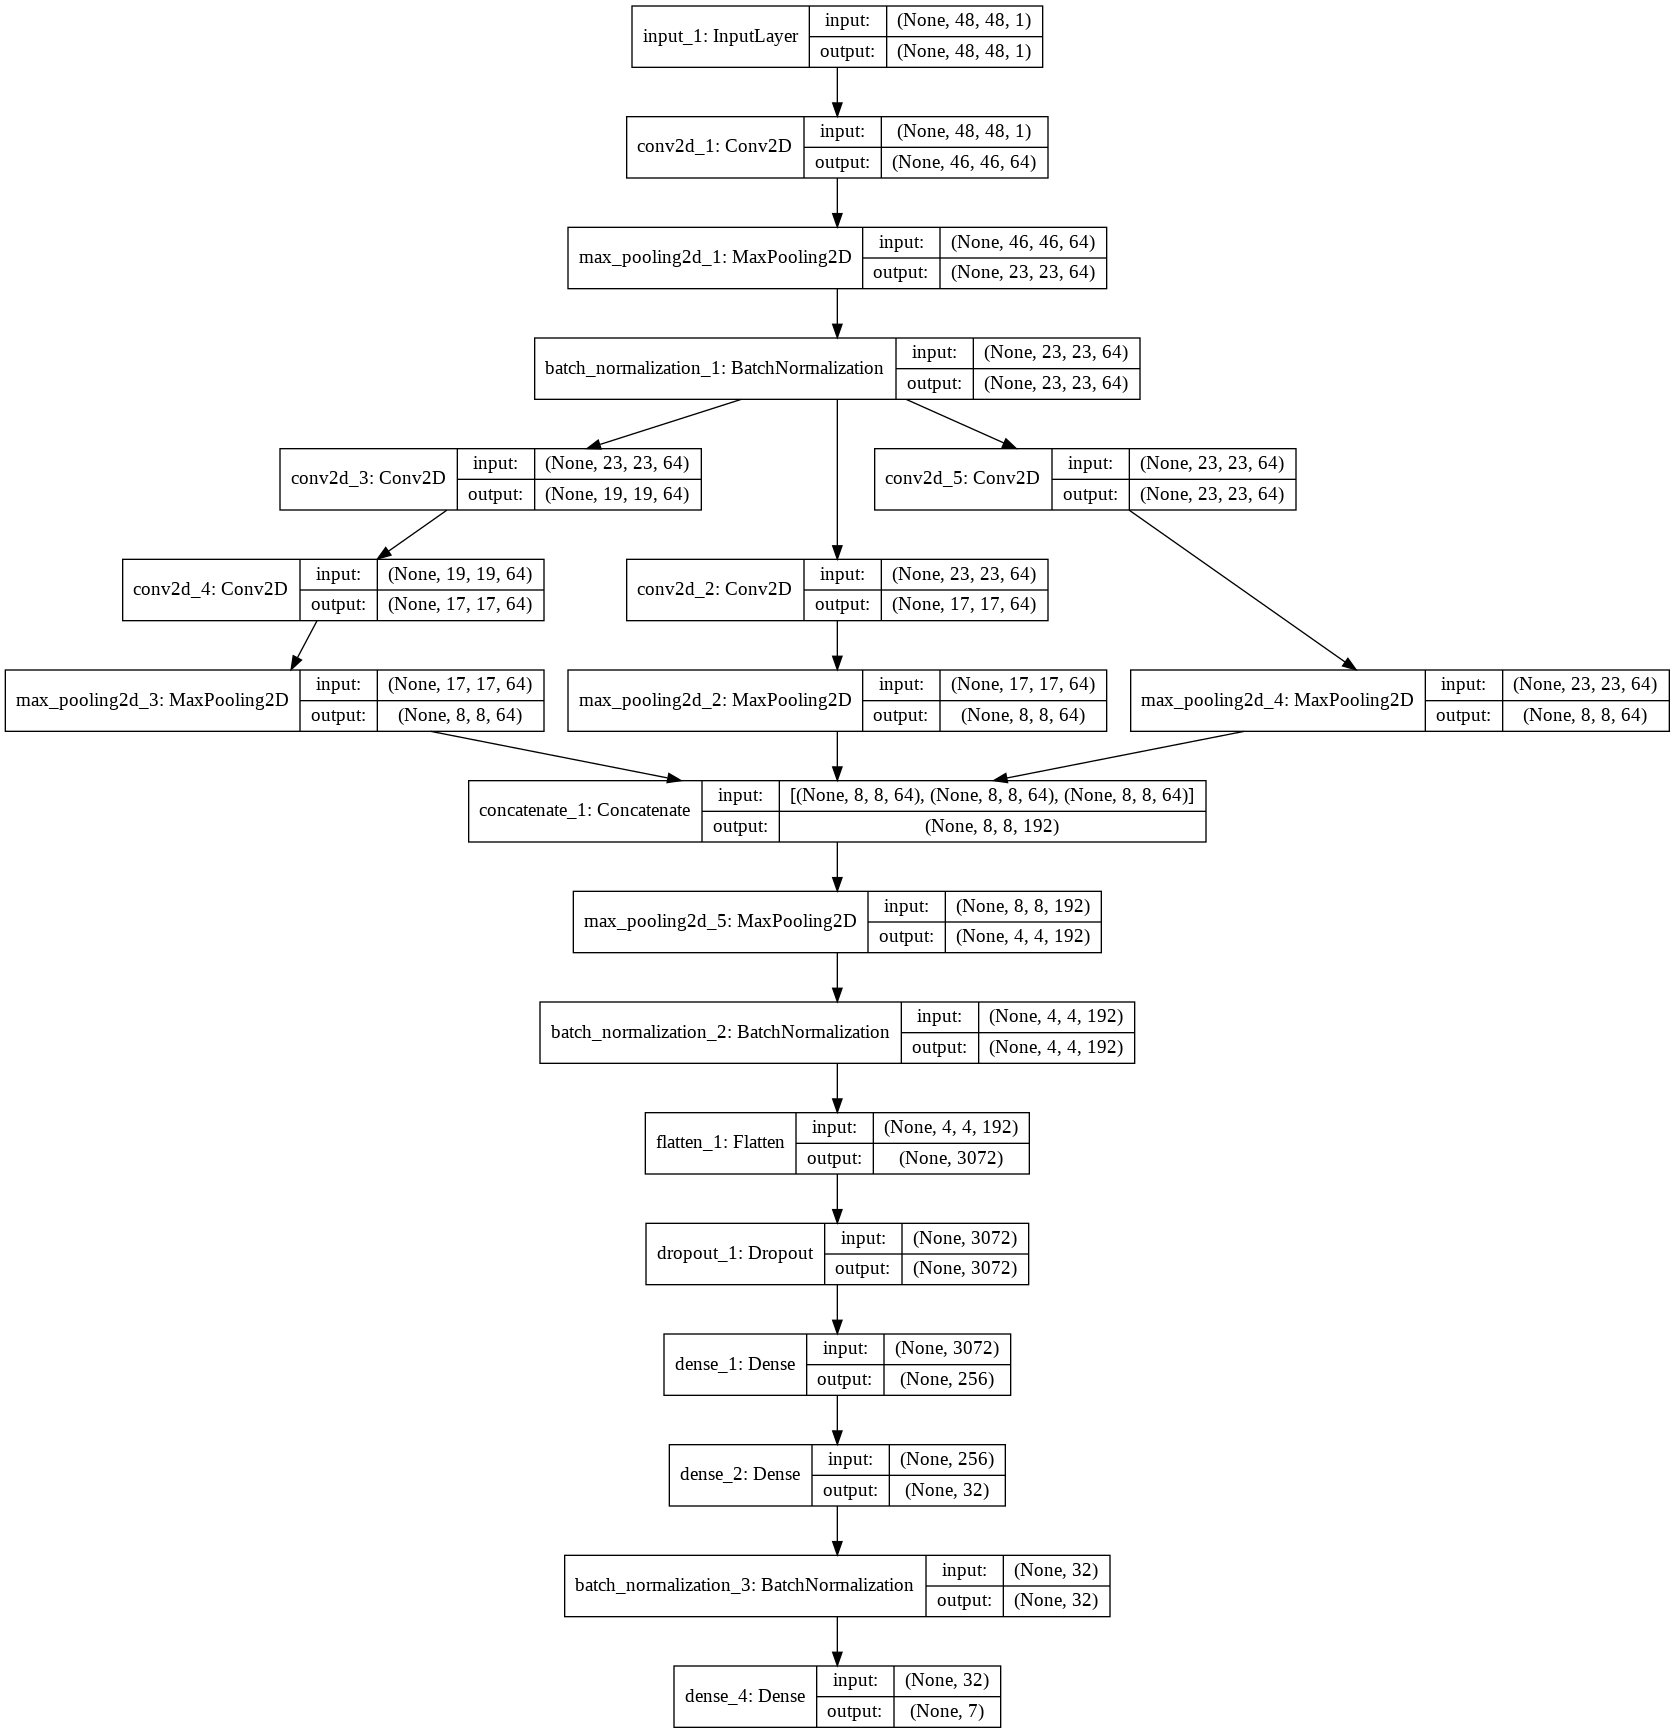

In [0]:
plot_model(model, show_shapes=True)

<a name="S12"></a>
## Création de callbacks

Les callbacks sont des fonctions qui permettent d'agir sur l'entraînement, en suivant certains paramètres. Cet outil est très utile par exemple pour éviter l'overfitting, en arrêtant l'entraînement lorsque le modèle commence à diverger.

In [0]:
class MyTreshold(tf.keras.callbacks.Callback):
    def __init__(self, threshold, param):
        self.threshold = threshold
        self.param = param

    def on_epoch_end(self, epoch, logs=None): 
        X = logs[self.param]
        if X >= self.threshold:
            self.model.stop_training = True
            print("\nEntrainement arrêté car le seuil demandé sur '{}' est atteint.".format(self.param))

In [0]:
param = 'acc'
seuil = 0.88
my_callback1 = MyTreshold(seuil,
                         param)
# pour arrêter l'entraînement si 'param' atteint la valeur 'seuil'

In [0]:
param2 = 'val_acc'
seuil2 = 10
my_callback2 = EarlyStopping(monitor=param2, 
                             patience=seuil2,
                             verbose=1)
# pour arrêter l'entraînement si 'param2' n'évolue plus sur 'seuil2' époques

In [0]:
param3 = 'val_loss'
seuil3 = 15 # pour être sur que le 'param3' diminue bien, on attend quelques époques, puisque les loss et acc du model fluctuent 
my_callback3 = EarlyStopping(monitor=param3, 
                             mode='min', #  l'entrainement s'arrêtera lorsque le 'monitor' aura cessé de diminuer
                             patience=seuil3, 
                             verbose=1)
# pour éviter l'overfitting ; l'entraînement s'arrêtera si 'param3' augmente, avec une patience de 'seuil3'

<a name="S13"></a>
## Entrainement du réseau

In [0]:
# batchsize = 128 pour FER2013 dataset
#               8 pour FER2013_small dataset
#               8 pour CK+
#               8 pour KDEF
#              64 pour la "petite fusion" (FER_small, CK+, KDEF) à 6 émotions
#             128 pour la "grande fusion" (FER, CK+, KDEF) à 6 émotions
history = model.fit(X_train, y_train,
                    batch_size = 128,
                    epochs = 50,
                    validation_split = 0.1,
                    callbacks = [my_callback3],
                    )

Train on 29068 samples, validate on 3230 samples
Epoch 1/50
29068/29068 [==============================] - 16s 534us/step - loss: 1.8108 - acc: 0.2990 - val_loss: 1.9378 - val_acc: 0.2604
Epoch 2/50
29068/29068 [==============================] - 15s 504us/step - loss: 1.5420 - acc: 0.4045 - val_loss: 1.6375 - val_acc: 0.3783
Epoch 3/50
29068/29068 [==============================] - 15s 504us/step - loss: 1.4356 - acc: 0.4490 - val_loss: 1.4950 - val_acc: 0.4337
Epoch 4/50
29068/29068 [==============================] - 15s 509us/step - loss: 1.3595 - acc: 0.4760 - val_loss: 1.5209 - val_acc: 0.4015
Epoch 5/50
29068/29068 [==============================] - 15s 505us/step - loss: 1.3089 - acc: 0.5015 - val_loss: 1.2820 - val_acc: 0.5201
Epoch 6/50
29068/29068 [==============================] - 15s 504us/step - loss: 1.2611 - acc: 0.5191 - val_loss: 1.2549 - val_acc: 0.5235
Epoch 7/50
29068/29068 [==============================] - 15s 504us/step - loss: 1.2343 - acc: 0.5318 - val_loss: 1.1

<a name="S14"></a>
#### Scores

Pour obtenir la précision du modèle, pour chaque dataset, on cherche à évaluer son score. 

Nous avons regroupé les scores de tous les datasets, et de leurs fusions, avec le deuxième modèle ci-dessous. En effet, les scores pour les datasets CK+ et KDEF étaient extrêmement bas avec le premier modèle.

In [0]:
# entrainé avec le premier modèle

# FER2013
train_score = encoder.evaluate(X_train, y_train, verbose=0)
test_score = encoder.evaluate(X_test, y_test, verbose=0)

print('Train loss: %.3f, Test loss: %.3f' % (train_score[0], test_score[0]))
print('Train acc: %.3f, Test acc: %.3f' % (train_score[1], test_score[1]))

Train loss: 0.298, Test loss: 1.263
Train acc: 0.910, Test acc: 0.631


In [0]:
# entrainé avec le second modèle

# FER2013
train_score = model.evaluate(X_train, y_train, verbose=0)
test_score = model.evaluate(X_test, y_test, verbose=0)

print('Train loss: %.3f, Test loss: %.3f' % (train_score[0], test_score[0]))
print('Train acc: %.3f, Test acc: %.3f' % (train_score[1], test_score[1]))

Train loss: 0.412, Test loss: 1.040
Train acc: 0.874, Test acc: 0.641


On remarque que la "accuracy" et la "validation accuraty" du dataset FER2013_small ci-dessous sont plus élevées que celles de FER2013, ci-dessus.

In [0]:
# FER2013_small
train_score = model.evaluate(X_train, y_train, verbose=0)
test_score = model.evaluate(X_test, y_test, verbose=0)

print('Train loss: %.3f, Test loss: %.3f' % (train_score[0], test_score[0]))
print('Train acc: %.3f, Test acc: %.3f' % (train_score[1], test_score[1]))

Train loss: 0.225, Test loss: 1.141
Train acc: 0.949, Test acc: 0.704


In [0]:
# CK+
train_score = model.evaluate(X_train, y_train, verbose=0)
test_score = model.evaluate(X_test, y_test, verbose=0)

print('Train loss: %.3f, Test loss: %.3f' % (train_score[0], test_score[0]))
print('Train acc: %.3f, Test acc: %.3f' % (train_score[1], test_score[1]))

Train loss: 0.018, Test loss: 0.039
Train acc: 1.000, Test acc: 1.000


In [0]:
# KDEF
train_score = model.evaluate(X_train, y_train, verbose=0)
test_score = model.evaluate(X_test, y_test, verbose=0)

print('Train loss: %.3f, Test loss: %.3f' % (train_score[0], test_score[0]))
print('Train acc: %.3f, Test acc: %.3f' % (train_score[1], test_score[1]))

Train loss: 0.241, Test loss: 1.155
Train acc: 0.937, Test acc: 0.591


In [0]:
# petite fusion : FER2013_small, CK+, KDEF (avec 6 émotions)
train_score = model.evaluate(X_train, y_train, verbose=0)
test_score = model.evaluate(X_test, y_test, verbose=0)

print('Train loss: %.3f, Test loss: %.3f' % (train_score[0], test_score[0]))
print('Train acc: %.3f, Test acc: %.3f' % (train_score[1], test_score[1]))

Train loss: 0.144, Test loss: 0.847
Train acc: 0.962, Test acc: 0.737


In [0]:
# grande fusion : FER2013, CK+, KDEF (avec 6 émotions)
train_score = model.evaluate(X_train, y_train, verbose=0)
test_score = model.evaluate(X_test, y_test, verbose=0)

print('Train loss: %.3f, Test loss: %.3f' % (train_score[0], test_score[0]))
print('Train acc: %.3f, Test acc: %.3f' % (train_score[1], test_score[1]))

Train loss: 0.337, Test loss: 0.902
Train acc: 0.900, Test acc: 0.672


<a name="S15"></a>
### Enregistrement du modèle

Dans l'optique de pouvoir réutiliser le modèle, les cellules ci-dessous permettent de sauvegarder le modèle.

In [0]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")
print("Modèle sauvegardé")

Modèle sauvegardé


Pour utiliser le modèle sauvegardé :

In [0]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("model.h5")
print("Modèle chargé")

Modèle chargé


In [0]:
# exemple de résultat
exemple = np.expand_dims(Pix_nb[0], axis=0)
np.round(loaded_model.predict(exemple), 2)

array([[0.98, 0.  , 0.  , 0.  , 0.02, 0.  , 0.  ]], dtype=float32)

### Visualisation de la loss et de l'accuracy

Exemple d'entrainement avec le modèle 1 sur le jeu de données FER2013 :

validation loss at the last epoch : 1.277


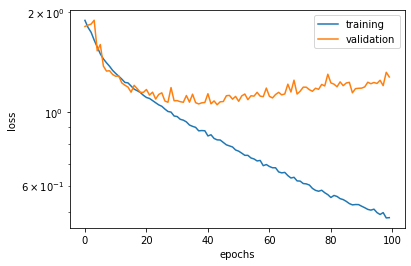

validation accuracy at the last epoch : 0.65


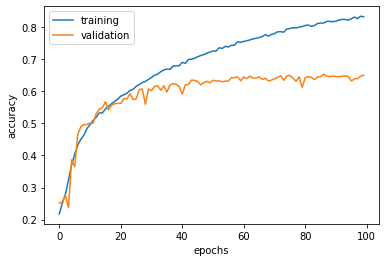

In [0]:
print('validation loss at the last epoch :', round(history.history['val_loss'][-1],3))

# visualisation de la loss
plt.semilogy(history.history['loss'], label='training')
plt.semilogy(history.history['val_loss'], label='validation')
plt.xlabel('epochs'); plt.ylabel('loss')
plt.legend()
plt.show()


print('validation accuracy at the last epoch :', round(history.history['val_acc'][-1],3))

# visualisation de la précision
plt.plot(history.history['acc'], label='training')
plt.plot(history.history['val_acc'], label='validation')
plt.xlabel('epochs'); plt.ylabel('accuracy'); plt.legend()
plt.show()

Ici, on remarque un léger overfitting puisque l'on peut voir la validation loss augmenter après 50 époques environ.

Exemple d'entrainement avec le modèle 2 sur le jeu de données FER2013 :

validation loss at the last epoch : 1.066


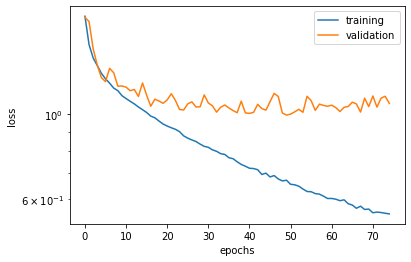

validation accuracy at the last epoch : 0.634


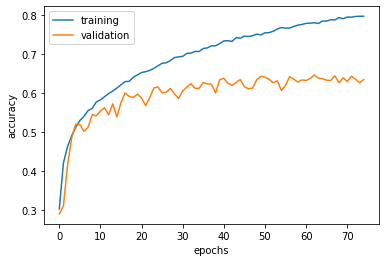

In [0]:
print('validation loss at the last epoch :', round(history.history['val_loss'][-1],3))

# visualisation de la loss
plt.semilogy(history.history['loss'], label='training')
plt.semilogy(history.history['val_loss'], label='validation')
plt.xlabel('epochs'); plt.ylabel('loss')
plt.legend()
plt.show()


print('validation accuracy at the last epoch :', round(history.history['val_acc'][-1],3))

# visualisation de la précision                
plt.plot(history.history['acc'], label='training')
plt.plot(history.history['val_acc'], label='validation')
plt.xlabel('epochs'); plt.ylabel('accuracy'); plt.legend()
plt.show()

Comme on l'a dit précédemment, les deux modèles obtiennent des résultats proches, les courbes de loss et de précision confirment cette hypothèse.

Exemple d'entrainement avec le modèle 2 sur le jeu de données CK+ :

validation loss at the last epoch : 0.052


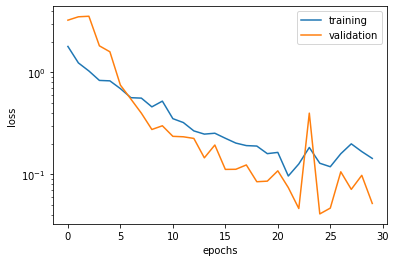

validation accuracy at the last epoch : 0.989


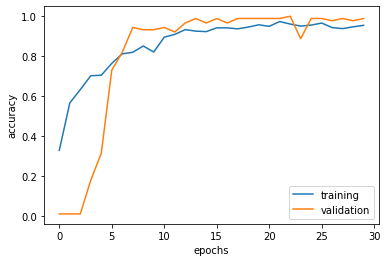

In [0]:
print('validation loss at the last epoch :', round(history.history['val_loss'][-1],3))

# visualisation de la loss
plt.semilogy(history.history['loss'], label='training')
plt.semilogy(history.history['val_loss'], label='validation')
plt.xlabel('epochs'); plt.ylabel('loss')
plt.legend()
plt.show()


print('validation accuracy at the last epoch :', round(history.history['val_acc'][-1],3))

# visualisation de la précision                
plt.plot(history.history['acc'], label='training')
plt.plot(history.history['val_acc'], label='validation')
plt.xlabel('epochs'); plt.ylabel('accuracy'); plt.legend()
plt.show()

On peut voir que la précision atteint très vite une valeur proche de 100%.

<a name="S16"></a>
# Visualisation des résultats


<a name="S17"></a>
## Exemples de prédictions

Dans cette partie, nous avons cherché à confronter les résultats de la prédiction du modèle avec les émotions labellisées.

En effet, on regroupe dans chaque `barplot` les pourcentages de reconnaissance des émotions pour une image et on les compare ainsi à l'émotion labellisée.



In [0]:
# Comparaison de la prédiction d'une image aléatoire des données de test et de son émotion labellisée
def result_random(Model):
    random_pix = np.random.randint(len(X_test)) # image random
    exemple = np.expand_dims(X_test[random_pix],axis=0) 
    res = (Model.predict(exemple)*100)[0] # prédiction

    emot_label = Emotions_labels.copy()
    if conflit: # si il y a une fusion des datasets avec CK+ dedans
        emot_label=emot_label[:6]

    print("Emotion selon le(s) dataset(s)", 
          emot_label[ np.argmax(y_test[random_pix]) ])

    plt.figure(figsize=(8,8))
    plt.subplot(211) # photo de l'exemple
    plt.imshow(exemple[0][:,:,0])

    plt.subplot(212) # barplot des émotions d'après le modèle
    plt.title("Emotion d'après le modèle")
    plt.bar(np.arange(len(list_emotions)), res, align='center')
    plt.xticks(np.arange(len(list_emotions)), emot_label[:len(list_emotions)])

    plt.show()

### Résultats majoritaires aux prédictions du modèle

Dans la majorité des cas, le modèle prédit une émotion avec plus de 80% de probabilité pour celle-ci :

Emotion selon le(s) dataset(s) surprise


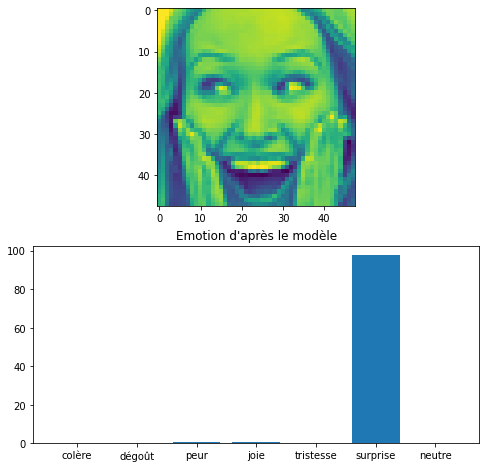

In [0]:
result_random(model) # exemple FER2013_small

Emotion selon le(s) dataset(s) peur


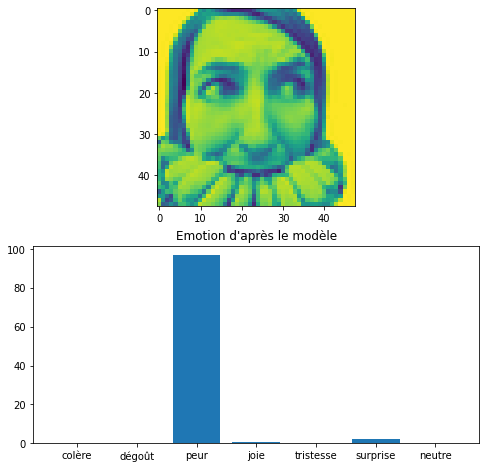

In [0]:
result_random(model) # exemple FER2013

Emotion selon le(s) dataset(s) tristesse


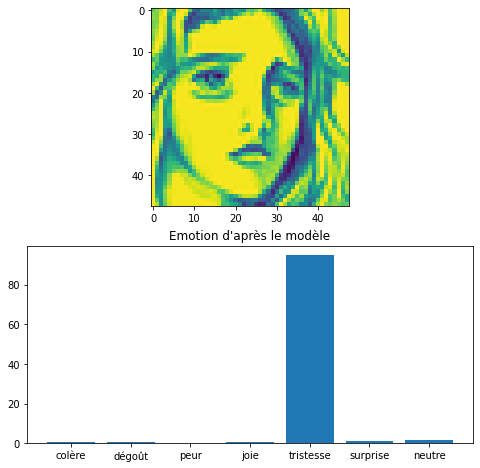

In [0]:
result_random(model) # exemple FER2013_small

Emotion selon le(s) dataset(s) joie


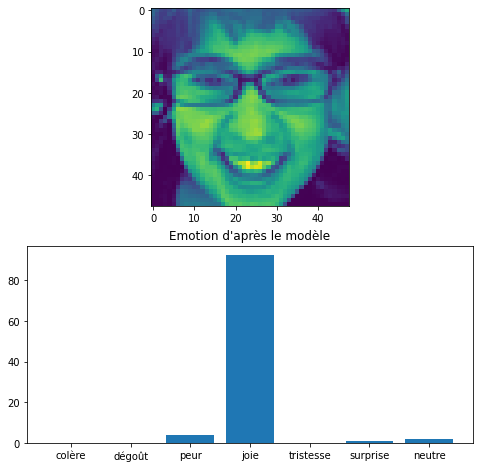

In [0]:
result_random(model) # exemple FER2013_small

Emotion selon le(s) dataset(s) surprise


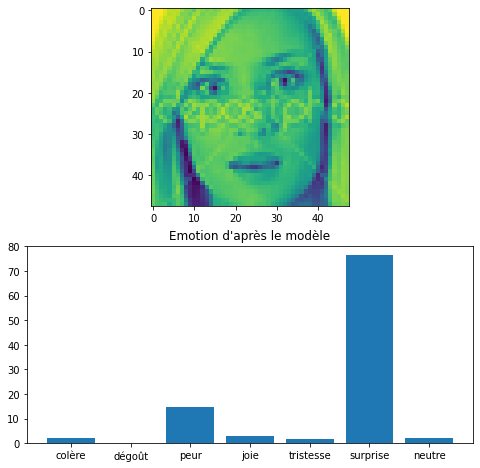

In [0]:
result_random(model) # exemple FER2013_small

Emotion selon le(s) dataset(s) tristesse


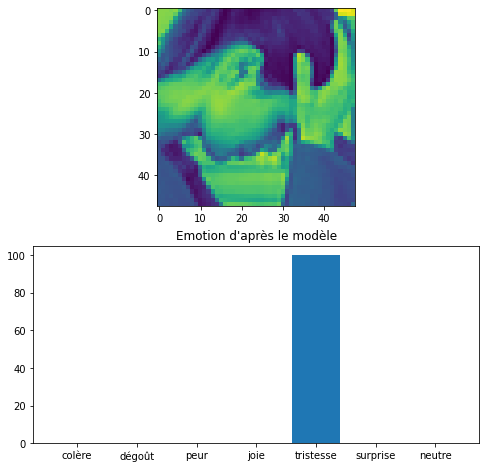

In [0]:
result_random(model) # exemple FER2013_small

On notera que pour les 6 images ci-dessus les mains, l'angle de la photo, les lunettes, du texte sur l'image, ou encore le fait que le visage soit un dessin n'entravent pas la prédiction.

Emotion selon le(s) dataset(s) joie


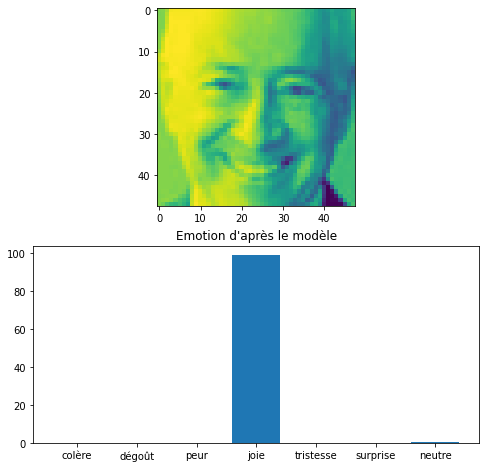

In [0]:
result_random(model) # exemple FER2013

Emotion selon le(s) dataset(s) colère


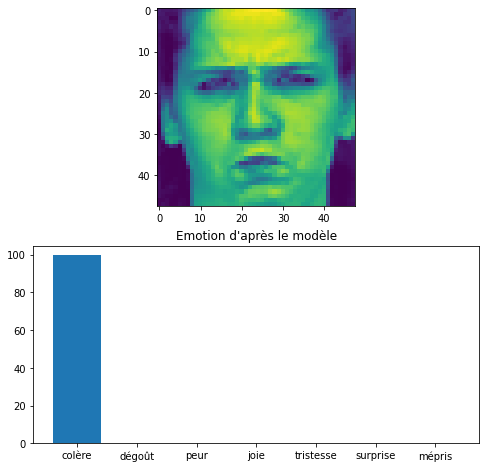

In [0]:
result_random(model) # exemple CK+

Emotion selon le(s) dataset(s) mépris


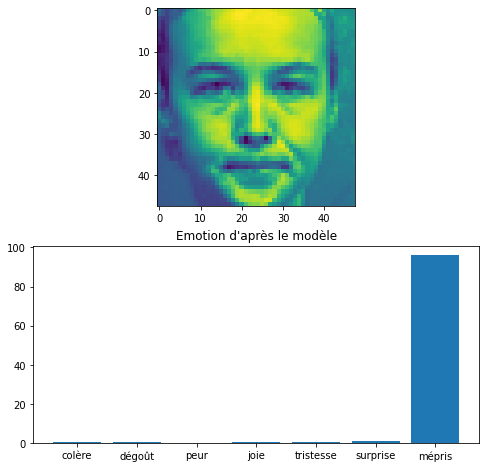

In [0]:
result_random(model) # exemple CK+

Emotion selon le(s) dataset(s) neutre


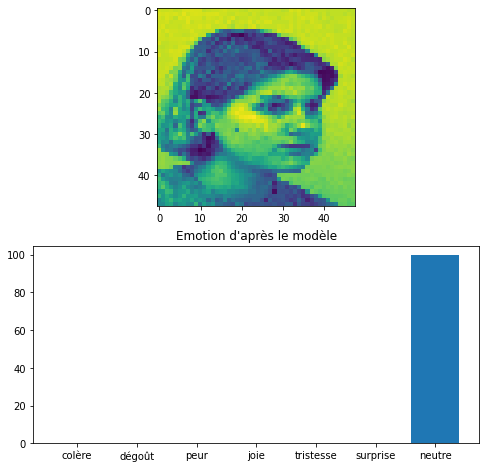

In [0]:
result_random(model) # exemple KDEF

### Autres types de résultats

Ci-dessous, nous sommes divisés sur l'émotion à choisir entre la peur et la surprise, et le modèle l'est également.

Emotion selon le(s) dataset(s) surprise


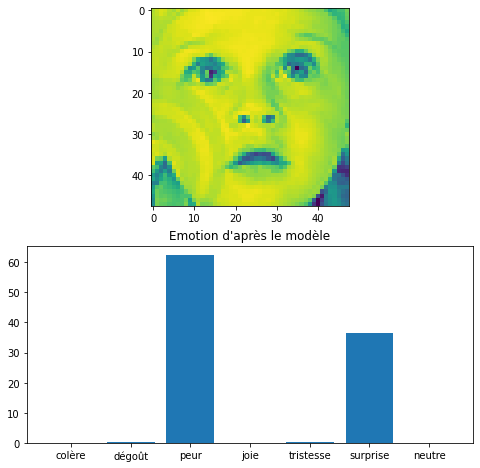

In [0]:
result_random(model) 

Pareil ici, l'émotion est entre la peur et la colère tout comme le modèle le prédit.

Emotion selon le(s) dataset(s) peur


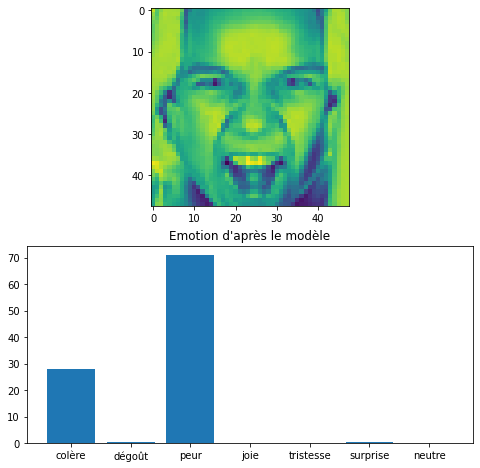

In [0]:
result_random(model) 

Dans les deux exemples ci-dessous, l'émotion labellisée est fausse, le modèle par contre prédit la bonne émotion.

Emotion selon le(s) dataset(s) neutre


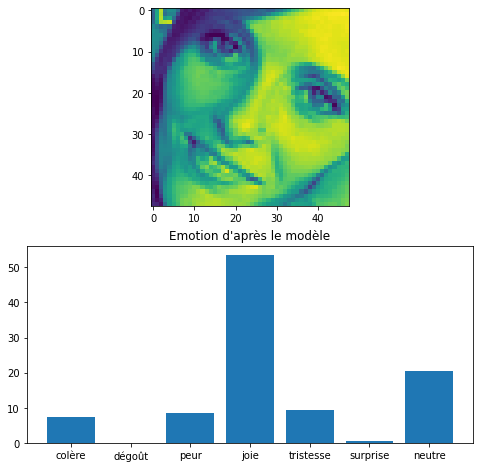

In [0]:
result_random(model) 

Emotion selon le(s) dataset(s) peur


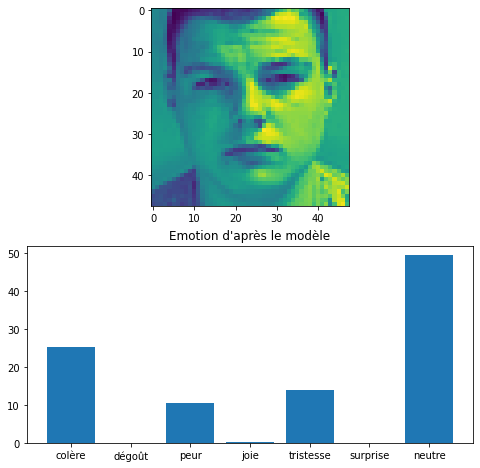

In [0]:
result_random(model)

Pour des émotions qui se ressemblent, dans le cas ci-dessous la peur, la tristesse et le mépris, le modèle peut les percevoir sur une image. Mais dans la plupart des cas, l'émotion labellisée est tout de même reconnue.

Emotion selon le(s) dataset(s) peur


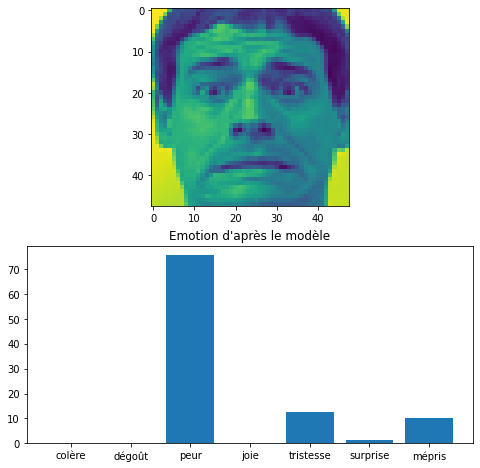

In [0]:
result_random(model) # exemple CK+

Ci-dessous, le modèle reconnaît trois émotions à des pourcentages plus ou moins égaux.
C'est dû au fait que la personne est de profil, et donc le modèle ne parvient pas à trancher sur un résultat exact.

Emotion selon le(s) dataset(s) tristesse


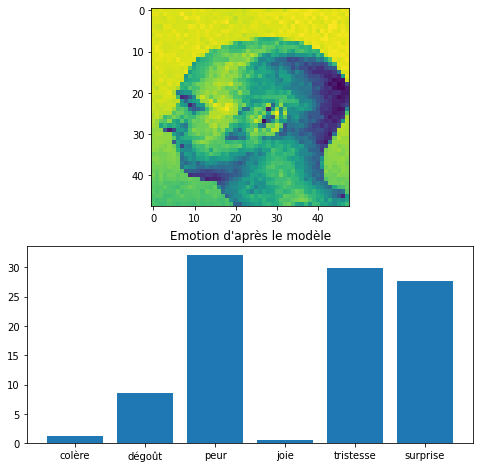

In [0]:
result_random(model) # exemple petite fusion

Nous avons vu que dans la plupart des cas les prédictions sont justes. Cependant, comme on vient de le voir, il existe bon nombre de cas particuliers dans lesquels notre modèle ne fait pas de choix tranché.

### Tests sur des images ne provenant pas des datasets

On peut tester notre modèle avec des images ne provenant pas des datasets importés.

In [0]:
def recup_image(name): # récupération d'image et prédiction associée
    image_get = image.load_img(name, target_size = (48, 48))
    image_get = image.img_to_array(image_get)[:,:,0]
    image_get = np.expand_dims(image_get, axis=0)
    image_get = np.expand_dims(image_get, axis=-1)

    res = (model.predict(image_get)*100)[0]

    plt.figure(figsize=(8,8))
    plt.subplot(211)
    plt.imshow(image_get[0][:,:,0], cmap='gray')

    plt.subplot(212)
    plt.bar(np.arange(len(list_emotions)), res, align='center')
    plt.xticks(np.arange(len(list_emotions)), Emotions_labels)

    plt.show()

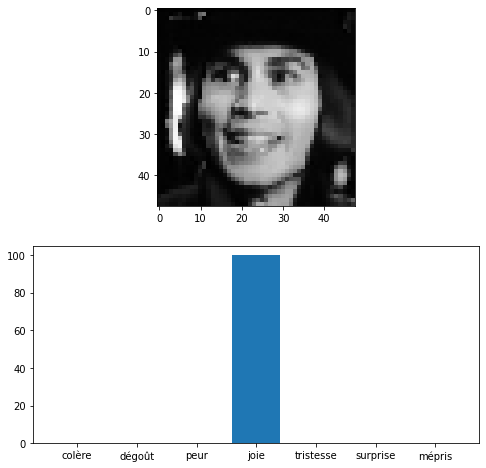

In [0]:
recup_image('datas/ww.jpg')

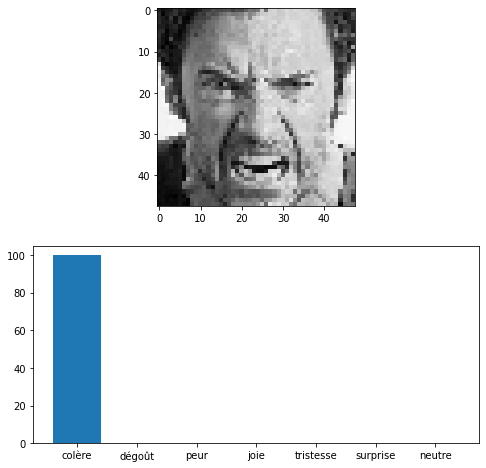

In [0]:
recup_image('datas/colère.jpg')

On peut voir qu'avec des images trouvées en dehors des datasets les prédictions sont bonnes.

On confronte ensuite notre modèle à des visages simplifiés au maximum, comme les emojis :

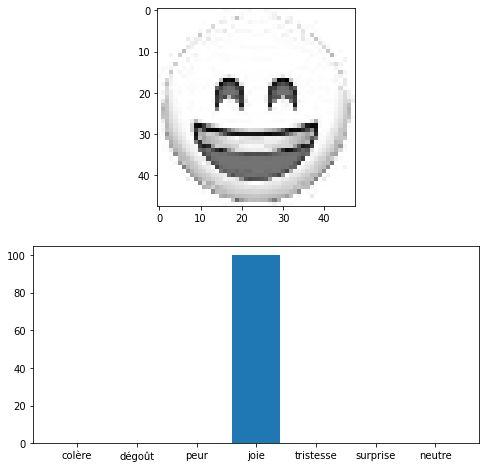

In [0]:
recup_image('datas/emoji_joie.jpg')

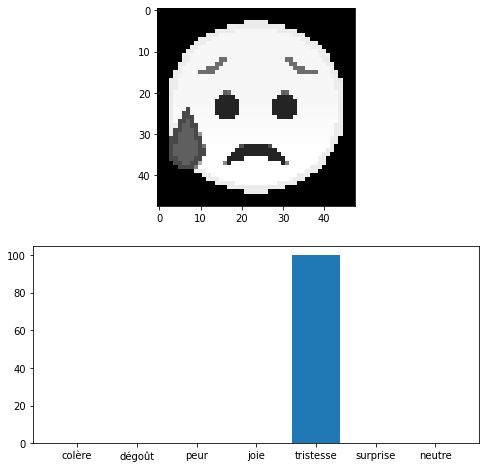

In [0]:
recup_image('datas/emoji_triste.png')

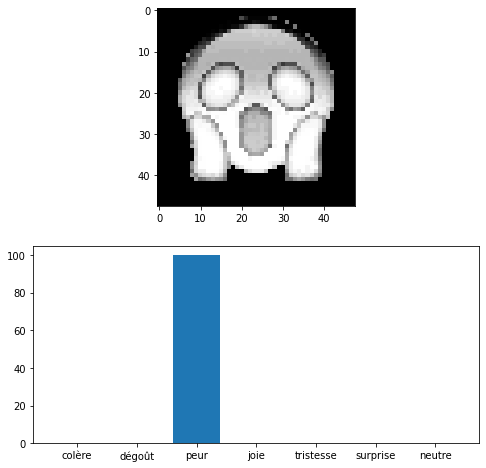

In [0]:
recup_image('datas/emoji_peur.png')

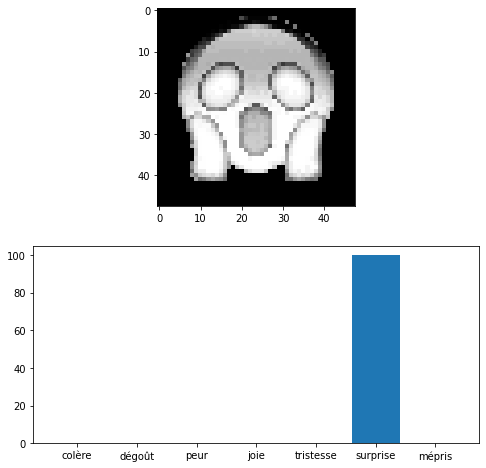

In [0]:
recup_image('datas/emoji_peur.png')

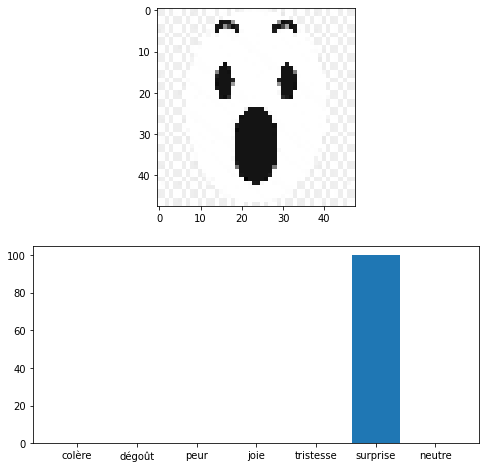

In [0]:
recup_image('datas/emoji_surprise.jpg')

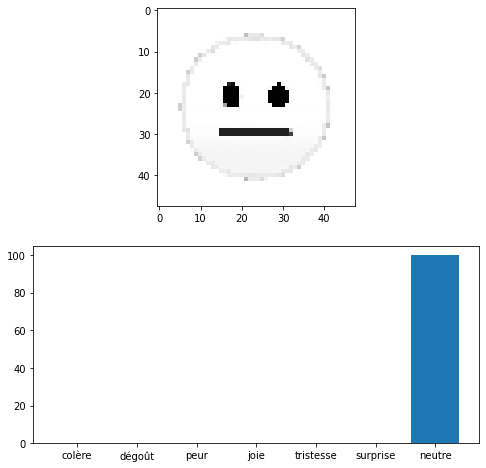

In [0]:
recup_image('datas/emoji_neutre.jpg') # rarement neutre, résultats très variés

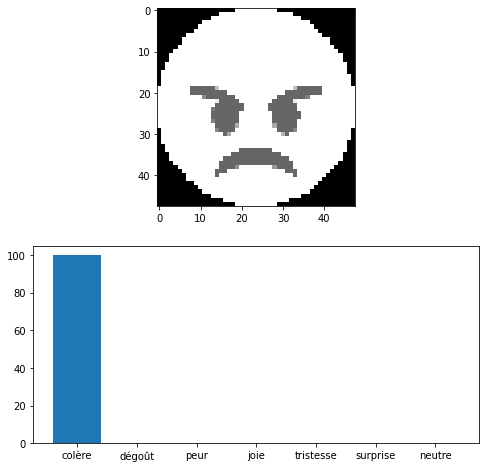

In [0]:
recup_image('datas/emoji_colère.png') # fer (sinon souvent peur)

Lorsque l'on confronte notre modèle avec des images particulières du type des emojis, les résultats sont assez variés.

Les résultats sont dépendant de l'entraînement et du dataset choisi et varient ainsi beaucoup. 
Le résultat peut être toujours bon comme pour la joie et la surprise, comme très souvent mauvais pour des émotions moins différenciables avec la tristesse, la peur ou la neutralité. 
Les emojis liés à ces dernières émotions donnent parfois des résultats surprenants, par exemple l'emoji tristesse est quelques fois prédit comme joie.

On remarquera que toutes les prédictions liées aux emojis sont toujours de 100% sur une émotion.
la simplicité des visages qu'ils expriment expliquent ce résultat.


<a name="S20"></a>
## Matrice de précision

Pour visualiser d'une autre manière nos résultats, nous avons cherché à obtenir une mesure de précision des modèles. 
Nous avons donc comparé les émotions par paire, pour mettre en évidence la différenciabilité entre les émotions. Les résultats sont regroupés dans des matrices de précision pour les différents datasets.

Le modèle a été entraîné à chaque fois sur un petit nombre d'époques pour éviter que toutes les émotions ne se retrouvent avec une discernabilité parfaite.

In [0]:
def Matrice(nb_epoch, b_size):

    emot_range = np.arange(7)
    matrice = np.zeros((7,7)) # matrice que l'on souhaite remplir

    for i in range(len(emot_range)):
        for j in range(len(emot_range)):
            if j<i:

                print("Couple d'émotions traité :",Emotions_labels[i], Emotions_labels[j])
                list_emotions=[emot_range[i],emot_range[j]] # le couple d'émotions considérées

                Pixels, Emot_nb = datas(list_emotions) # images et émotions associées

                Emot_nb = pd.get_dummies(pd.Series(Emot_nb)).values.astype(None) # get_dummies emotions

                X_train, X_test, y_train, y_test = train_test_split(Pixels,Emot_nb,test_size=0.2) # split

                # On lance le modèle pour chaque paire d'émotions
                output_shape = 2
                model, LK = getModel_2(output_shape)
                model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['acc'])

                #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                history = model.fit(X_train, y_train,
                                    batch_size=b_size,
                                    epochs=nb_epoch,
                                    validation_split=0.1,
                                    verbose=0,
                                    )
                #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

                train_acc = model.evaluate(X_train, y_train, verbose=0)[1]

                print('train accuracy :', train_acc)
                print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n')
                matrice[i,j]=train_acc

    return matrice

In [0]:
def precision_map(Mat): # affichage de la matrice de précision
    plt.figure(figsize=(9,7))
    plt.imshow(Mat, cmap='Greens')

    for (j,i),label in np.ndenumerate(np.round(Mat,2)):
        if Mat[j,i]!=0:
            plt.text(i,j,label,ha='center',va='center')
            plt.text(i,j,label,ha='center',va='center')

    plt.xticks(np.arange(7), Emotions_labels)
    plt.yticks(np.arange(7), Emotions_labels)
    
    plt.colorbar()

Dataset FER2013, pour les deux modèles :

In [0]:
mat_FER = Matrice(10, 128)

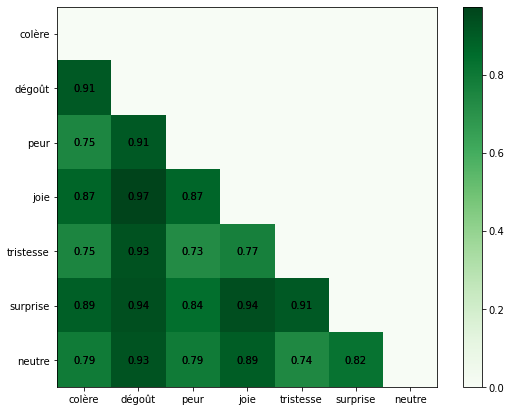

In [0]:
precision_map(mat_FER) # avec model 1

In [0]:
mat_FER = Matrice(10, 128)

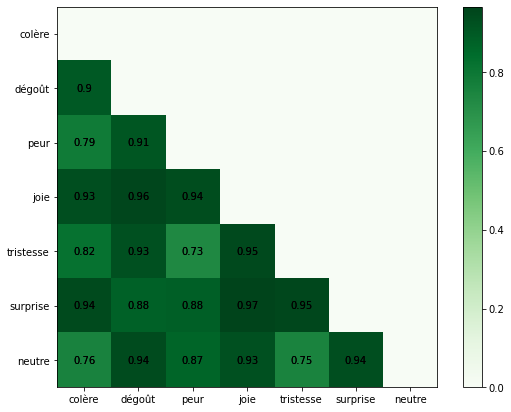

In [0]:
precision_map(mat_FER) # avec model 2

On remarque ici que le modèle 2 a une précision légèrement meilleure que le modèle 1 comme dit précédemment.

Dataset FER2013_small : 

In [0]:
mat_FER_small = Matrice(10, 8)

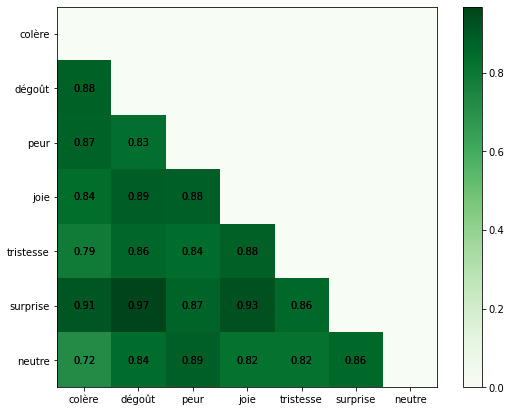

In [0]:
precision_map(mat_FER_small)

En égalisant le dataset FER2013, les précisions par paire sont plus proches les unes des autres.

Dataset CK+ :

In [0]:
mat_CK = Matrice(10, 4)

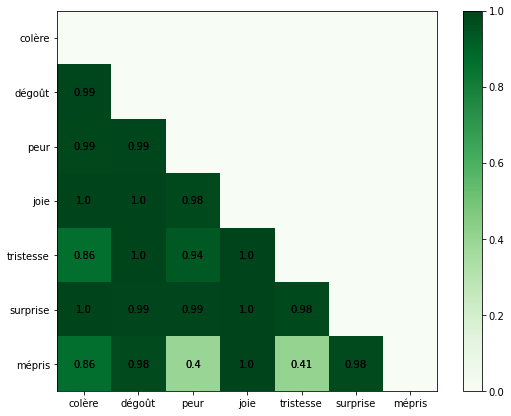

In [0]:
precision_map(mat_CK)

Ici, les émotions sont presque toutes reconnues parfaitement par le modèle même avec un très faible nombre d'époques.
Les émotions mépris, peur et tristesse étant très proches visuellement, on remarque une précision beaucoup plus faible entre elles.



Dataset KDEF :

In [0]:
mat_KDEF = Matrice(10, 16)

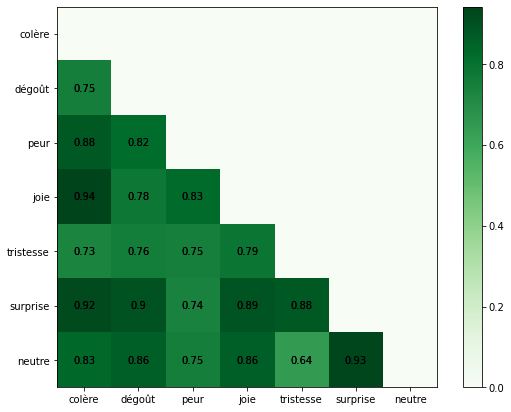

In [0]:
precision_map(mat_KDEF)

Les précisions sur ce dataset sont moins bonnes que pour les autres datasets.
On retrouve quand même les émotions surprise et joie en émotions les mieux différenciées.

Les matrices de précision nous ont donc permis de comparer les émotions et les datasets.
On observe que les émotions joie et surprise sont celles qui se démarquent le plus.
Tandis que les émotions comme la tristesse, la peur et la neutralité, ou le mépris dans le cas de CK+, sont souvent confondues.






<a name="S18"></a>
## Espace Latent

Dans cette partie, nous avons utilisé la réduction de dimension pour visualiser l'espace latent des prédictions des modèles. 

Cet espace, à 2 ou 3 dimensions, permet de séparer les émotions en clusters si l'entraînement est assez bon.

In [0]:
def latentspace(X, Model_choice, dim, *hide_ax):
    X_encoded = Model_choice.predict(X) # prédiction

    # réduction de dimension
    if dim==2: 
        tsne = manifold.TSNE(n_components=2, init='pca', random_state=0) 
    if dim==3: 
        tsne = manifold.TSNE(n_components=3, init='pca', random_state=0)
    
    X_tsne = tsne.fit_transform(X_encoded)

    # scatterplot 2D
    if dim==2:
        print('2D projection')
        plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=np.argmax(y_test,axis=1))
        plt.colorbar()
        plt.show()

    # scatterplot 3D
    if dim==3:
        print('3D projection')
        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c=np.argmax(y_test,axis=1))
        if hide_ax:
            ax.set_axis_off()

        return fig, ax

def rotate(angle): # utilisé dans la visualisation 3D animée
    ax.view_init(azim=angle)

2D projection


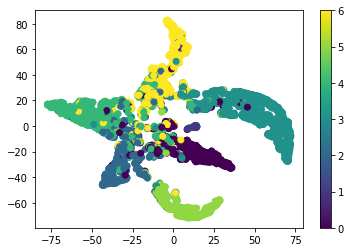

In [0]:
latentspace(X_test, model,2)

On a ici un exemple de séparation presque parfaite en 7 groupes distincts, reliés au centre.

#### Visualisation pour 7 émotions

Grâce à la visualisation de l'espace latent, la différenciation des clusters est possible pour chaque émotion. Chaque cluster de couleur correspond donc à une émotion. 

\
Les cas ci-dessous sont issus de la prédiction sur le dataset FER2013 qui possède un grand nombre d'images. Les clusters sont donc assez larges et se relient au centre.

On distingue à chaque fois 7 groupements correspondant aux 7 émotions. Des clusters se chevauchent lorsque les émotions sont assez proches visuellement.
Certains sont beaucoup plus petits que d'autres puisque, dans ce jeu de données, le nombre d'images par émotion est assez irrégulier.

##### Avec le premier modèle :

2D projection


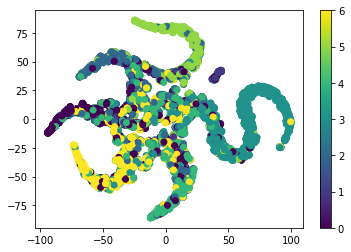

In [0]:
latentspace(X_test, last_dense,2) 

2D projection


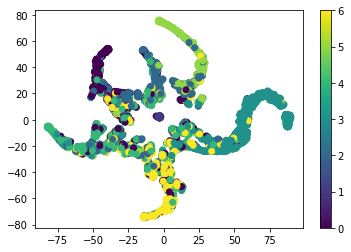

In [0]:
latentspace(X_test, encoder,2)

##### Avec le deuxième modèle :

2D projection


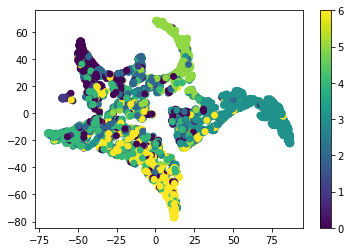

In [0]:
latentspace(X_test, model,2)

2D projection


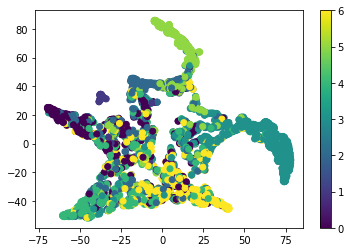

In [0]:
latentspace(X_test, model,2)

On peut voir que les émotions joie et surprise (3 et 5) forment des clusters assez séparés des autres émotions. Ce sont donc les émotions les plus facilement différenciables.

Avec FER2013_small, le nombre de données est réduit mais on distingue toujours assez bien les 7 clusters créés par les émotions :

2D projection


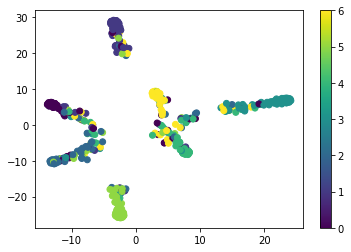

In [0]:
latentspace(X_test, model,2)

Avec le dataset CK+, le nombre d'images est bien inférieur donc les clusters sont extrèment petits.
On remarque q'une multitude de prédictions peuvent même être regroupées en un seul point.



2D projection


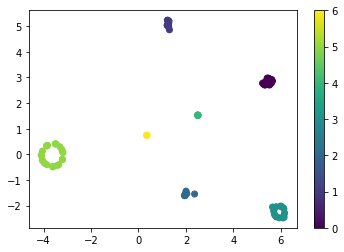

In [0]:
latentspace(X_test, model,2)

Avec KDEF, la séparation de certaines émotions est difficile mais on retrouve toujours un arrangement en clusters :

2D projection


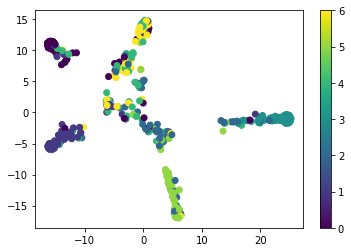

In [0]:
latentspace(X_test, model,2)

#### Visualisation avec 2, 3, 4 et 5 émotions

2D projection


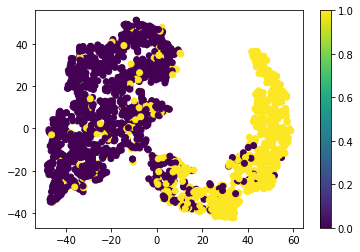

In [0]:
latentspace(X_test, last_dense,2) # avec 2 émotions

In [0]:
HTML(anim.to_html5_video()) # visualisation en 3D

2D projection


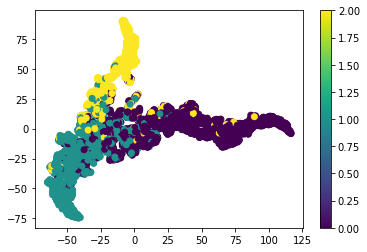

In [0]:
latentspace(X_test, last_dense,2) # avec 3 émotions

In [0]:
HTML(anim.to_html5_video()) # visualisation en 3D

2D projection


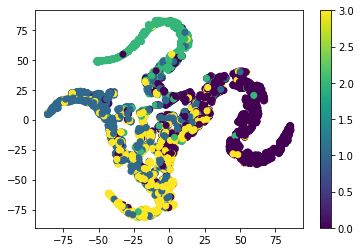

In [0]:
latentspace(X_test, encoder,2) # avec 4 émotions

2D projection


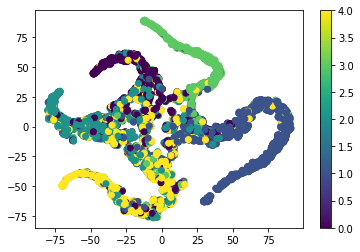

In [0]:
latentspace(X_test, encoder,2) # avec 5 émotions

De 2 à 5 émotions, on voit très nettement les différents clusters représentant les émotions. 

Les clusters se chevauchent au centre puisqu'il y a toujours des images pour lesquelles plusieurs émotions peuvent être perçues. 

<a name="S19"></a>
## Courbes ROC 

Une courbe ROC (Receiver Operating Characteristic) est une courbe de probabilité et son AUC (Area Under the Curve) représente le degré de séparabilité.
Cela nous indique dans quelle mesure le modèle est capable de distinguer les émotions.
Plus l'AUC est grande, plus notre modèle sera capable de distinguer les émotions.

Les micro et macro moyenne que l'on présente dans les résultats ci-dessous nous permettent de mieux apprécier les résultats dans l'ensemble.
En effet, en plus de voir les courbes de chaque émotion, la micro et la macro moyenne vont prendre en compte toutes les émotions, mais pas de la même manière.
La différence est que la micro moyenne va tenir compte du nombre d'images qu'il y a par émotion, tandis que la macro moyenne fera un calcul plus simpliste.
La micro moyenne sera donc préférable dans des datasets où il y a un déséquilibre dans le nombre d'éléments de chaque émotion.


In [0]:
def ROC_curves(X_test):
    prediction = model.predict(X_test)
    n_classes = len(list_emotions)

    # courbe ROC et AUC pour chaque émotion
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], prediction[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])


    # courbe ROC et AUC de la micro moyenne
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), prediction.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


    # courbe ROC et AUC de la macro moyenne

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    return fpr, tpr, roc_auc

In [0]:
def ROC_plot(limits): # Plot all ROC curves
    n_classes = len(list_emotions)

    plt.title('ROC')

    plt.plot(fpr["micro"], tpr["micro"], 'r:', lw=4,
            label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))

    plt.plot(fpr["macro"], tpr["macro"], 'b:', lw=4,
            label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]))


    if len(Pix)==len(Pix2): # si le seul dataset est CK+
        Emotions_labels[-1]='mépris'
    else:
        Emotions_labels[-1]='neutre'

    cols=iter(plt.cm.rainbow(np.linspace(0,1,n_classes)))
    for i in range(n_classes):
        color=next(cols)
        plt.plot(fpr[i], tpr[i], color=color,
                label="ROC pour l'émotion {0} (area = {1:0.2f})".format(Emotions_labels[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')

    plt.xlim(limits[:2]) 
    plt.ylim(limits[-2:])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.legend(bbox_to_anchor=(1, 1))
    plt.show()

FER2013 dataset, ROC visualisation

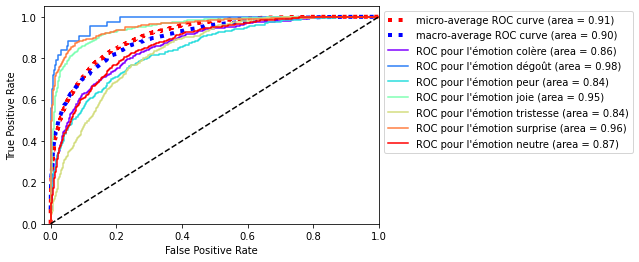

In [0]:
fpr, tpr, roc_auc = ROC_curves(X_test)

normal=[-0.02, 1, 0, 1.05]
ROC_plot(normal)

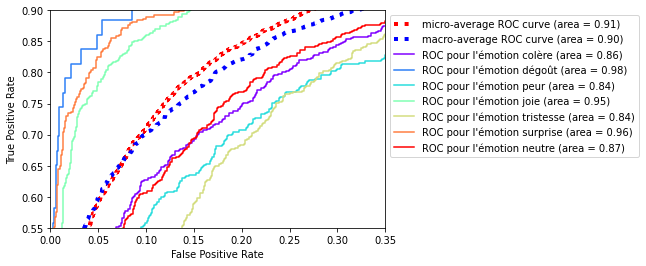

In [0]:
zoom=[0, 0.35, 0.55, 0.9]
ROC_plot(zoom)

FER2013_small dataset, ROC visualisation

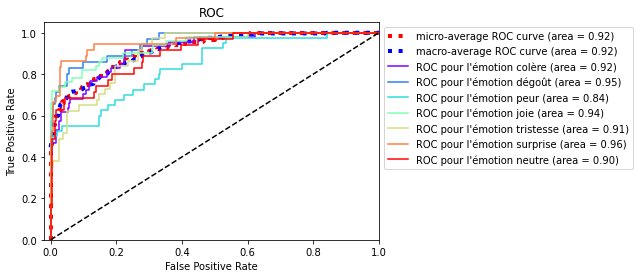

In [0]:
fpr, tpr, roc_auc = ROC_curves(X_test)

normal=[-0.02, 1, 0, 1.05]
ROC_plot(normal)

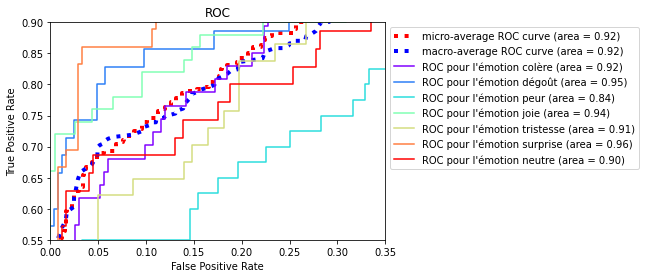

In [0]:
zoom=[0, 0.35, 0.55, 0.9]
ROC_plot(zoom)

CK+ dataset, ROC visualisation

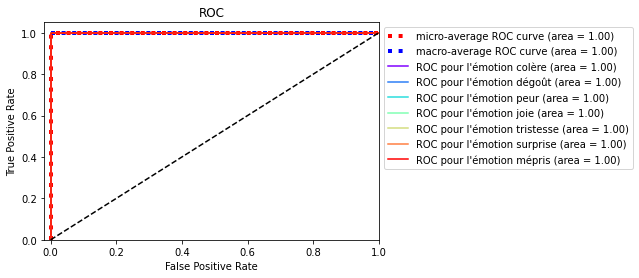

In [0]:
fpr, tpr, roc_auc = ROC_curves(X_test)

normal=[-0.02, 1, 0, 1.05]
ROC_plot(normal)

KDEF dataset, ROC visualisation

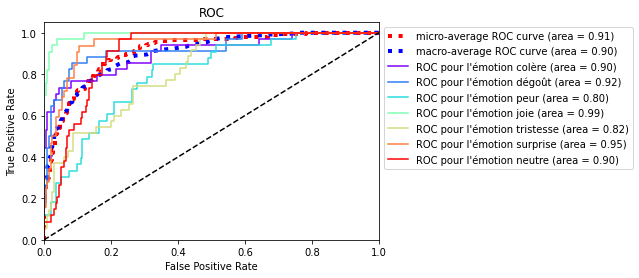

In [0]:
fpr, tpr, roc_auc = ROC_curves(X_test)

normal=[0, 1, 0, 1.05]
ROC_plot(normal)

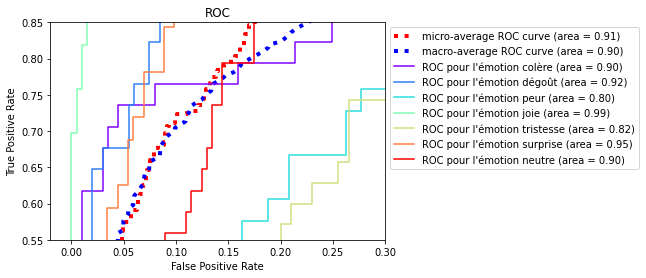

In [0]:
zoom=[-0.02, 0.3, 0.55, 0.85]
ROC_plot(zoom)

Pour l'ensemble des jeux de données, les courbes moyennes ROC ont des aires assez élevées, avec peu de déviation des émotions à la moyenne. 
Les datasets FER2013 et KDEF ont des AUC de 0.90 ce qui signifie que le modèle est assez sûr de lui quant à ses résultats.

On rappellera qu'un bon modèle a une AUC proche de 1. ce qui signifie que les émotions sont bien différenciables.


En équilibrant le nombre d'images par émotion dans le dataset FER2013, on observe avec les courbes ROC de FER2013_small, que les émotions sont plus resserrées que sur le graph avec le dataset complet. 
L'émotion dégoût, qui était la plus différenciée dans les courbes ROC de FER2013, se rapproche maintenant plus des autres. 
On retrouve toujours la peur en émotion la moins précisément différenciée par le modèle.


La précision du modèle avec le jeu de données CK+ atteignant 100%, on obtient une ROC parfaite avec uniquement des résultats "vrais positifs". Ceci est lié au fait que le jeu de données ne possède pas d'erreurs et que les émotions sont "forcées" par la personne, donc plus reconnaissables.

### Courbes ROC des grandes et petites fusions de datasets

Après avoir étudié les courbes ROC pour chaque dataset, nous avons voulu tester en fusionnant tous les datasets.
On rappelle que CK+ possède l'émotion mépris alors que les deux autres datasets l'émotion neutre. Nous avons donc retiré ces émotions et comparé les datasets sur les 6 émotions restantes.

Fusion des datasets FER2013_small, CK+ et KDEF

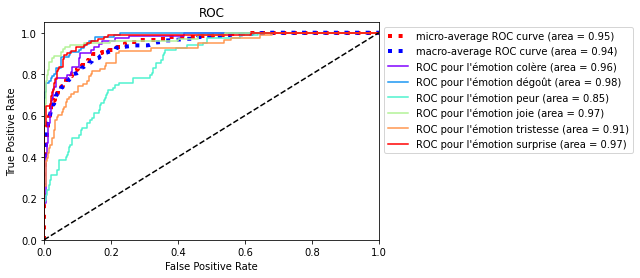

In [0]:
fpr, tpr, roc_auc = ROC_curves(X_test)

normal=[0, 1, 0, 1.05]
ROC_plot(normal)

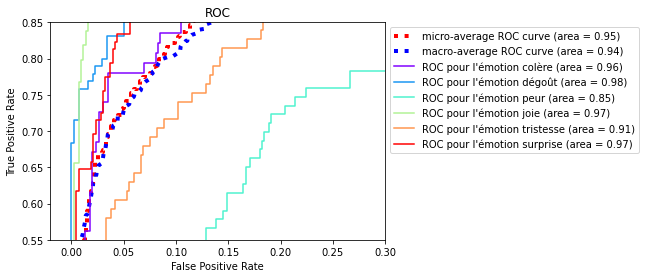

In [0]:
zoom=[-0.02, 0.3, 0.55, 0.85]
ROC_plot(zoom)

L'association des 3 jeux de données permet d'obtenir une grande diversité dans les images et le modèle parvient à capter plus d'information d'où le bon résultat ci-dessus (0.95 de micro-average ROC curve area).

Grande fusion des datasets FER2013, CK+ et KDEF

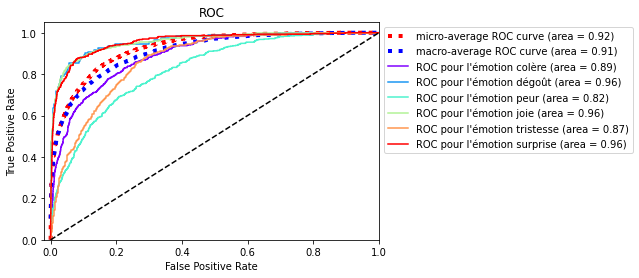

In [0]:
fpr, tpr, roc_auc = ROC_curves(X_test)

normal=[-0.02, 1, 0, 1.05]
ROC_plot(normal)

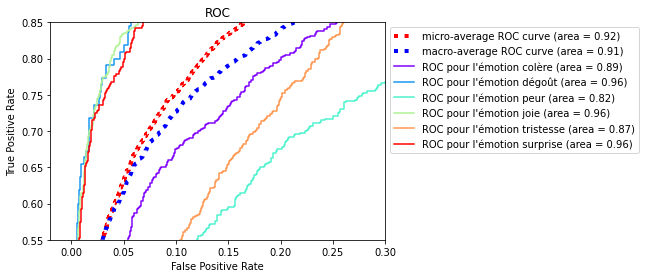

In [0]:
zoom=[-0.02, 0.3, 0.55, 0.85]
ROC_plot(zoom)

Dans cette fusion, on observe que les résultats sont très similaires à ceux du dataset FER2013 seul. Cela est dû au fait que le dataset FER2013 est largement dominant en terme de nombre d'images par rapport aux deux autres datasets.

<a name="S21"></a>
# Conclusion

Avec des [exemples de prédictions](#S17) sous forme de probabilités d'émotions, nous avons obtenu une première approche des résultats que les modèles pouvaient nous donner. 
Ces simples visualisations nous donnent beaucoup d'informations sur le fonctionnement des modèles.
Nous avons vu que les éléments perturbateurs ne génaient pas le modèle dans la plupart des cas et que les visages n'avaient pas forcément besoin d'être humain pour qu'une émotion soit reconnue.


Grâce aux [matrices de précision](#S20), nous avons pu établir des liens entre paires d'émotions et nous avons vu que, pour tous les jeux de données, il existe des émotions facilement différenciables de part leurs traits uniques comme la joie ou la surprise ; et à l'inverse, des émotions qui se confondent comme la peur, la tristesse ou la neutralité (le mépris pour CK+).


Avec la réduction de dimension, nous avons obtenu les graphiques des [espaces latents](#S18) qui nous permettent de visualiser les clusters créés par chaque émotion. Ceux-ci nous donnent de bonnes indications sur la proximité et la différenciabilité des émotions.

Enfin, avec les [courbes ROC](#S19), nous avons été en mesure d'établir des degrés de séparabilité entre émotions.
Avec un jeu de données sans erreurs (CK+) cette séparabilité est parfaite et toutes les émotions sont discernables par le modèle.


Du fait de la forte similitude entre la peur et la tristesse sur les traits du visage, ces émotions sont souvent confondues par les modèles. 
Cela peut se voir sur l'espace latent du dataset FER2013, les zones 1 et 3 sont entremêlées et dans la matrice de précision elles sont difficilement différenciables. On a aussi vu que ces émotions avaient les AUC les plus faibles. 

En revanche, les émotions surprise et joie sont les mieux différenciées par les modèles. Elles forment des clusters bien distincts dans les espaces latents, leurs AUC sont extrêmement élevées et elles possèdent les scores les plus élevés dans les matrices de précision.



\
Les modèles que nous avons développés fonctionnent très bien et même au delà de nos espérances pour le dataset CK+ puisque la précision atteint 100%. 
Mais ce jeu de données n'est pas totalement représentatif de la réalité puisque les visages expriment de façon non naturelle les émotions.

Or les algorithmes d'aujourd'hui doivent pouvoir faire face à tout type de situation, et savoir reconnaître l'émotion sans pour autant devoir forcer les traits caractéristiques de ces émotions, comme on peut le voir dans le jeu de données FER2013 où de nombreux éléments perturbateurs surviennent et les visages sont naturels.

Avec ces jeux de données là, nos modèles parviennent à obtenir une précision de l'ordre de 70% ce qui est tout de même assez élevé pour 7 émotions et malgré tous les imprévus dans les données.


\
Pour notre projet, les imperfections dans les jeux de données représentaient une limite certaine en entravant le bon fonctionnnement des modèles. En effet, que ce soit des mains, du texte sur le visage, ou autre, le modèle ne peut pas savoir si cela fait partie intégrante du visage de la personne et la précision s'en retrouve diminuée.

De plus, l'incohérence entre jeux de données au niveau de la dernière émotion nous empêche de les comparer pleinement.


\
Une suite pertinente à cette étude serait d'étendre le nombre d'émotions au maximum pour apprécier encore mieux les possibilités offertes par le deep learning en terme de reconnaissance faciale.


Pour aller plus loin, il serait aussi intéressant de passer à une prédiction des émotions en direct avec un support vidéo.





[Revenir en haut de la page](#exit)